# Barkwear Data Analysis
## Table of Contents

1. [Setup and Imports](#setup-and-imports)
2. [Dataset Overview](#dataset-overview)
3. [Google AudioSet Dog Data Analysis](#google-audioset-dog-data-analysis)
   - [Ontology Loading and Processing](#ontology-loading-and-processing)
   - [Data Loading Pipeline](#data-loading-pipeline)
   - [Basic Statistics](#basic-statistics)
   - [Label Distribution Analysis](#label-distribution-analysis)
   - [Dog-Specific Sound Analysis](#dog-specific-sound-analysis)
   - [Temporal Analysis](#temporal-analysis)
   - [Video Duration Analysis](#video-duration-analysis)
4. [Kaggle Dog Inertia and Behavior Analysis Dataset](#kaggle-dog-inertia-and-behavior-analysis-dataset)
   - [Data Preprocessing](#data-preprocessing)
   - [Task Type Distributions](#task-type-distributions)
   - [Behavior Distributions](#behavior-distributions)
   - [Sensor Data Distributions](#sensor-data-distributions)
5. [DogCentric Activity Dataset](#dogcentric-activity-dataset)
6. [DECADE ego centric video](#decade-ego-centric-video)

---


## Setup and Imports


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import warnings
import os
import re
import json
from pathlib import Path

# Configure plotting
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10
warnings.filterwarnings('ignore')

# Print versions for reproducibility
print("Library Versions:")
print(f"pandas: {pd.__version__}")
print(f"numpy: {np.__version__}")
print(f"matplotlib: {plt.matplotlib.__version__}")
print(f"seaborn: {sns.__version__}")

# Set working directory paths
base_path = Path("../")
audioset_path = base_path / "audioset_dog"
kaggle_behavior_path = base_path / "kaggle1_behavior_analysis_data"
kaggle_inertial_path = base_path / "kaggle_inertial_data"
signals_path = base_path / "dataset_signals"

print("\nData directories found:")
for path in [audioset_path, kaggle_behavior_path, kaggle_inertial_path, signals_path]:
    print(f"  {path}: {path.exists()}")


Library Versions:
pandas: 2.3.1
numpy: 2.0.1
matplotlib: 3.10.0
seaborn: 0.13.2

Data directories found:
  ../audioset_dog: True
  ../kaggle1_behavior_analysis_data: True
  ../kaggle_inertial_data: False
  ../dataset_signals: True


## Dataset Overview

Let's start by understanding the available datasets and their characteristics.


In [2]:
# Dataset overview
datasets_info = {
    'Google AudioSet Dog Data': {
        'path': audioset_path,
        'description': 'Audio segments with dog-related sounds from YouTube videos',
        'modality': 'Audio',
        'size': '13,705 videos total'
    },
    'Kaggle Behavior Analysis': {
        'path': kaggle_behavior_path,
        'description': 'Dog behavior analysis with movement data',
        'modality': 'Behavioral/Movement',
        'size': 'TBD'
    },
    'Kaggle Inertial Data': {
        'path': kaggle_inertial_path,
        'description': 'Inertial sensor data from dog movement',
        'modality': 'Sensor/IMU',
        'size': 'TBD'
    }
}

print("Available Datasets:")
print("=" * 60)
for name, info in datasets_info.items():
    print(f"\n{name}:")
    print(f"  Path: {info['path']}")
    print(f"  Description: {info['description']}")
    print(f"  Modality: {info['modality']}")
    print(f"  Size: {info['size']}")
    print(f"  Exists: {info['path'].exists()}")

# List files in each directory
print("\n\nFile Structure:")
print("=" * 60)
for name, info in datasets_info.items():
    if info['path'].exists():
        print(f"\n{name} files:")
        try:
            files = list(info['path'].iterdir())
            for file in sorted(files)[:10]:  # Show first 10 files
                if file.is_file():
                    size = file.stat().st_size / (1024*1024)  # MB
                    print(f"  📄 {file.name} ({size:.1f} MB)")
                elif file.is_dir():
                    print(f"  📁 {file.name}/")
            if len(files) > 10:
                print(f"  ... and {len(files) - 10} more files")
        except Exception as e:
            print(f"  Error accessing directory: {e}")


Available Datasets:

Google AudioSet Dog Data:
  Path: ../audioset_dog
  Description: Audio segments with dog-related sounds from YouTube videos
  Modality: Audio
  Size: 13,705 videos total
  Exists: True

Kaggle Behavior Analysis:
  Path: ../kaggle1_behavior_analysis_data
  Description: Dog behavior analysis with movement data
  Modality: Behavioral/Movement
  Size: TBD
  Exists: True

Kaggle Inertial Data:
  Path: ../kaggle_inertial_data
  Description: Inertial sensor data from dog movement
  Modality: Sensor/IMU
  Size: TBD
  Exists: False


File Structure:

Google AudioSet Dog Data files:
  📄 .DS_Store (0.0 MB)
  📁 audioset_v1_embeddings/
  📄 balanced_train_segments.csv (1.2 MB)
  📄 eval_segments.csv (1.1 MB)
  📄 ontology.json (0.3 MB)
  📄 qa_true_counts.csv (0.0 MB)
  📄 rerated_video_ids.txt (1.5 MB)
  📄 unbalanced_train_segments.csv (96.8 MB)

Kaggle Behavior Analysis files:
  📄 Data_description.txt (0.0 MB)
  📄 DogInfo.xlsx (0.0 MB)
  📄 DogMoveData.csv (1893.6 MB)


## Google AudioSet Dog Data Analysis

### Ontology Loading and Processing

Let's load the AudioSet ontology to properly map label IDs to meaningful names and understand the hierarchical structure of dog-related sounds.

### Source:

https://research.google.com/audioset/dataset/index.html


In [3]:
# Load and process the AudioSet ontology
def load_audioset_ontology():
    """Load the AudioSet ontology from ontology.json and create useful mappings."""
    
    ontology_file = audioset_path / "ontology.json"
    
    with open(ontology_file, 'r') as f:
        ontology = json.load(f)
    
    # Create basic mapping dictionaries
    id_to_name = {}
    id_to_info = {}
    parent_to_children = defaultdict(list)
    child_to_parents = defaultdict(list)
    
    # Process ontology entries
    for entry in ontology:
        label_id = entry['id']
        label_name = entry['name']
        
        # Basic mappings
        id_to_name[label_id] = label_name
        id_to_info[label_id] = entry
        
        # Build hierarchy mappings
        for child_id in entry.get('child_ids', []):
            parent_to_children[label_id].append(child_id)
            child_to_parents[child_id].append(label_id)
    
    return {
        'ontology': ontology,
        'id_to_name': id_to_name,
        'id_to_info': id_to_info,
        'parent_to_children': parent_to_children,
        'child_to_parents': child_to_parents
    }

# Load ontology
ontology_data = load_audioset_ontology()
print("AudioSet Ontology Loaded:")
print(f"  Total entries: {len(ontology_data['ontology'])}")
print(f"  Total labels: {len(ontology_data['id_to_name'])}")

# Find dog-related entries
dog_id = "/m/0bt9lr"
dog_info = ontology_data['id_to_info'].get(dog_id, {})

print(f"\n🐕 DOG SOUND HIERARCHY:")
print("=" * 40)
print(f"Main Dog ID: {dog_id}")
print(f"Name: {dog_info.get('name', 'Unknown')}")
print(f"Description: {dog_info.get('description', 'No description')}")

# Get all dog child sounds
dog_child_ids = dog_info.get('child_ids', [])
print(f"\nDog-specific sounds ({len(dog_child_ids)} types):")
for child_id in dog_child_ids:
    child_info = ontology_data['id_to_info'].get(child_id, {})
    child_name = child_info.get('name', 'Unknown')
    child_desc = child_info.get('description', 'No description')
    print(f"  {child_id}: {child_name}")
    print(f"    Description: {child_desc[:80]}{'...' if len(child_desc) > 80 else ''}")

# Get parent categories
dog_parents = ontology_data['child_to_parents'].get(dog_id, [])
print(f"\nParent categories:")
for parent_id in dog_parents:
    parent_name = ontology_data['id_to_name'].get(parent_id, 'Unknown')
    print(f"  {parent_id}: {parent_name}")

# Create comprehensive dog-related sound set (including all children and grandchildren)
def get_all_descendants(label_id, parent_to_children, max_depth=3):
    """Get all descendant IDs for a given label ID."""
    descendants = set()
    to_process = [(label_id, 0)]
    
    while to_process:
        current_id, depth = to_process.pop(0)
        if depth <= max_depth:
            descendants.add(current_id)
            for child_id in parent_to_children.get(current_id, []):
                to_process.append((child_id, depth + 1))
    
    return descendants

# Get all dog-related sounds (including dog itself and all children)
all_dog_sounds = get_all_descendants(dog_id, ontology_data['parent_to_children'])
print(f"\nAll dog-related sound IDs ({len(all_dog_sounds)} total):")
for sound_id in sorted(all_dog_sounds):
    sound_name = ontology_data['id_to_name'].get(sound_id, 'Unknown')
    print(f"  {sound_id}: {sound_name}")

# Store for later use
ontology_data['all_dog_sounds'] = all_dog_sounds
ontology_data['dog_child_ids'] = dog_child_ids


AudioSet Ontology Loaded:
  Total entries: 632
  Total labels: 632

🐕 DOG SOUND HIERARCHY:
Main Dog ID: /m/0bt9lr
Name: Dog
Description: Any sounds coming from the familiar domesticated canid which has been selectively bred over millennia for companionship, protection, as well as for superior sensory capabilities, and other useful behaviors.

Dog-specific sounds (7 types):
  /m/05tny_: Bark
    Description: Principal communication sound produced by dogs. Often transliterated as woof, es...
  /m/07r_k2n: Yip
    Description: A sharp high-pitched bark or cry, typically from a miniature dog.
  /m/07qf0zm: Howl
    Description: The long plaintive cry of a dog, wolf, or other canidae.
  /m/07rc7d9: Bow-wow
    Description: Dog communication sound that is more tonal and less abrupt than a classic bark.
  /m/0ghcn6: Growling
    Description: A low, guttural vocalization produced by animals as a warning, a sign of aggress...
  /t/dd00136: Whimper (dog)
    Description: Muted dog vocalization i

### Data Loading Pipeline


In [4]:
# Load the CSV files from AudioSet using the ontology for better label handling
def load_audioset_data_with_ontology(ontology_data):
    """Load all AudioSet CSV files and enhance them with ontology information."""
    
    datasets = {}
    
    # Define the CSV files to load
    csv_files = {
        'balanced_train': audioset_path / 'balanced_train_segments.csv',
        'unbalanced_train': audioset_path / 'unbalanced_train_segments.csv',
        'eval': audioset_path / 'eval_segments.csv'
    }
    
    for dataset_name, file_path in csv_files.items():
        if file_path.exists():
            print(f"Loading {dataset_name}...")
            
            # Read the file, skipping the header lines that start with #
            with open(file_path, 'r') as f:
                lines = f.readlines()
            
            # Find where data starts (after # comments)
            data_start = 0
            header_info = {}
            for i, line in enumerate(lines):
                if line.startswith('#'):
                    # Parse header information
                    if 'created' in line:
                        header_info['created'] = line.strip()
                    elif 'num_' in line:
                        header_info['stats'] = line.strip()
                    elif 'YTID' in line:
                        # This is the column header
                        header_info['columns'] = line.strip('# \n').split(', ')
                        data_start = i + 1
                        break
            
            # Read the actual data
            data_lines = lines[data_start:]
            
            # Parse data into DataFrame with enhanced label information
            rows = []
            for line in data_lines:
                if line.strip():  # Skip empty lines
                    parts = [part.strip() for part in line.strip().split(', ')]
                    if len(parts) >= 4:  # Ensure we have all required columns
                        ytid, start_sec, end_sec, labels = parts[0], float(parts[1]), float(parts[2]), parts[3]
                        
                        # Parse labels (remove quotes and split by comma)
                        label_list = [label.strip().strip('"') for label in labels.strip('"').split(',')]
                        
                        # Enhance with ontology information
                        label_names = [ontology_data['id_to_name'].get(label_id, label_id) for label_id in label_list]
                        
                        # Check for dog-related labels
                        dog_labels = [label_id for label_id in label_list if label_id in ontology_data['all_dog_sounds']]
                        dog_label_names = [ontology_data['id_to_name'].get(label_id, label_id) for label_id in dog_labels]
                        
                        # Check for specific dog sound types
                        specific_dog_labels = [label_id for label_id in label_list if label_id in ontology_data['dog_child_ids']]
                        specific_dog_names = [ontology_data['id_to_name'].get(label_id, label_id) for label_id in specific_dog_labels]
                        
                        rows.append({
                            'ytid': ytid,
                            'start_seconds': start_sec,
                            'end_seconds': end_sec,
                            'duration': end_sec - start_sec,
                            'positive_labels': label_list,
                            'positive_label_names': label_names,
                            'num_labels': len(label_list),
                            'has_dog_sounds': len(dog_labels) > 0,
                            'dog_labels': dog_labels,
                            'dog_label_names': dog_label_names,
                            'num_dog_labels': len(dog_labels),
                            'specific_dog_labels': specific_dog_labels,
                            'specific_dog_names': specific_dog_names,
                            'num_specific_dog_labels': len(specific_dog_labels)
                        })
            
            df = pd.DataFrame(rows)
            df['dataset'] = dataset_name
            
            datasets[dataset_name] = {
                'data': df,
                'header_info': header_info,
                'file_size_mb': file_path.stat().st_size / (1024*1024)
            }
            
            print(f"  Loaded {len(df)} segments")
            print(f"  Dog-related segments: {df['has_dog_sounds'].sum()}")
            print(f"  File size: {datasets[dataset_name]['file_size_mb']:.1f} MB")
            print(f"  Header info: {header_info.get('stats', 'N/A')}")
        else:
            print(f"File not found: {file_path}")
    
    return datasets

# Load all AudioSet data with ontology enhancement
audioset_data = load_audioset_data_with_ontology(ontology_data)

# Combine all datasets for analysis
all_segments = []
for dataset_name, dataset_info in audioset_data.items():
    all_segments.append(dataset_info['data'])

combined_df = pd.concat(all_segments, ignore_index=True)

print(f"\nCombined Dataset Summary:")
print(f"Total segments: {len(combined_df)}")
print(f"Segments with dog sounds: {combined_df['has_dog_sounds'].sum()}")
print(f"Segments with specific dog vocalizations: {combined_df['num_specific_dog_labels'].sum()}")
print(f"Unique videos: {combined_df['ytid'].nunique()}")
print(f"Dataset distribution:")
print(combined_df['dataset'].value_counts())


Loading balanced_train...
  Loaded 22160 segments
  Dog-related segments: 359
  File size: 1.2 MB
  Header info: # num_ytids=22160, num_segs=22160, num_unique_labels=527, num_positive_labels=52882
Loading unbalanced_train...
  Loaded 2041789 segments
  Dog-related segments: 16290
  File size: 96.8 MB
  Header info: # num_ytids=2041789, num_segs=2041789, num_unique_labels=527, num_positive_labels=4020212
Loading eval...
  Loaded 20371 segments
  Dog-related segments: 320
  File size: 1.1 MB
  Header info: # num_ytids=20371, num_segs=20371, num_unique_labels=527, num_positive_labels=51804

Combined Dataset Summary:
Total segments: 2084320
Segments with dog sounds: 16969
Segments with specific dog vocalizations: 12330
Unique videos: 2084320
Dataset distribution:
dataset
unbalanced_train    2041789
balanced_train        22160
eval                  20371
Name: count, dtype: int64


### Basic Statistics


AudioSet Dog Data - Basic Statistics (with Ontology)


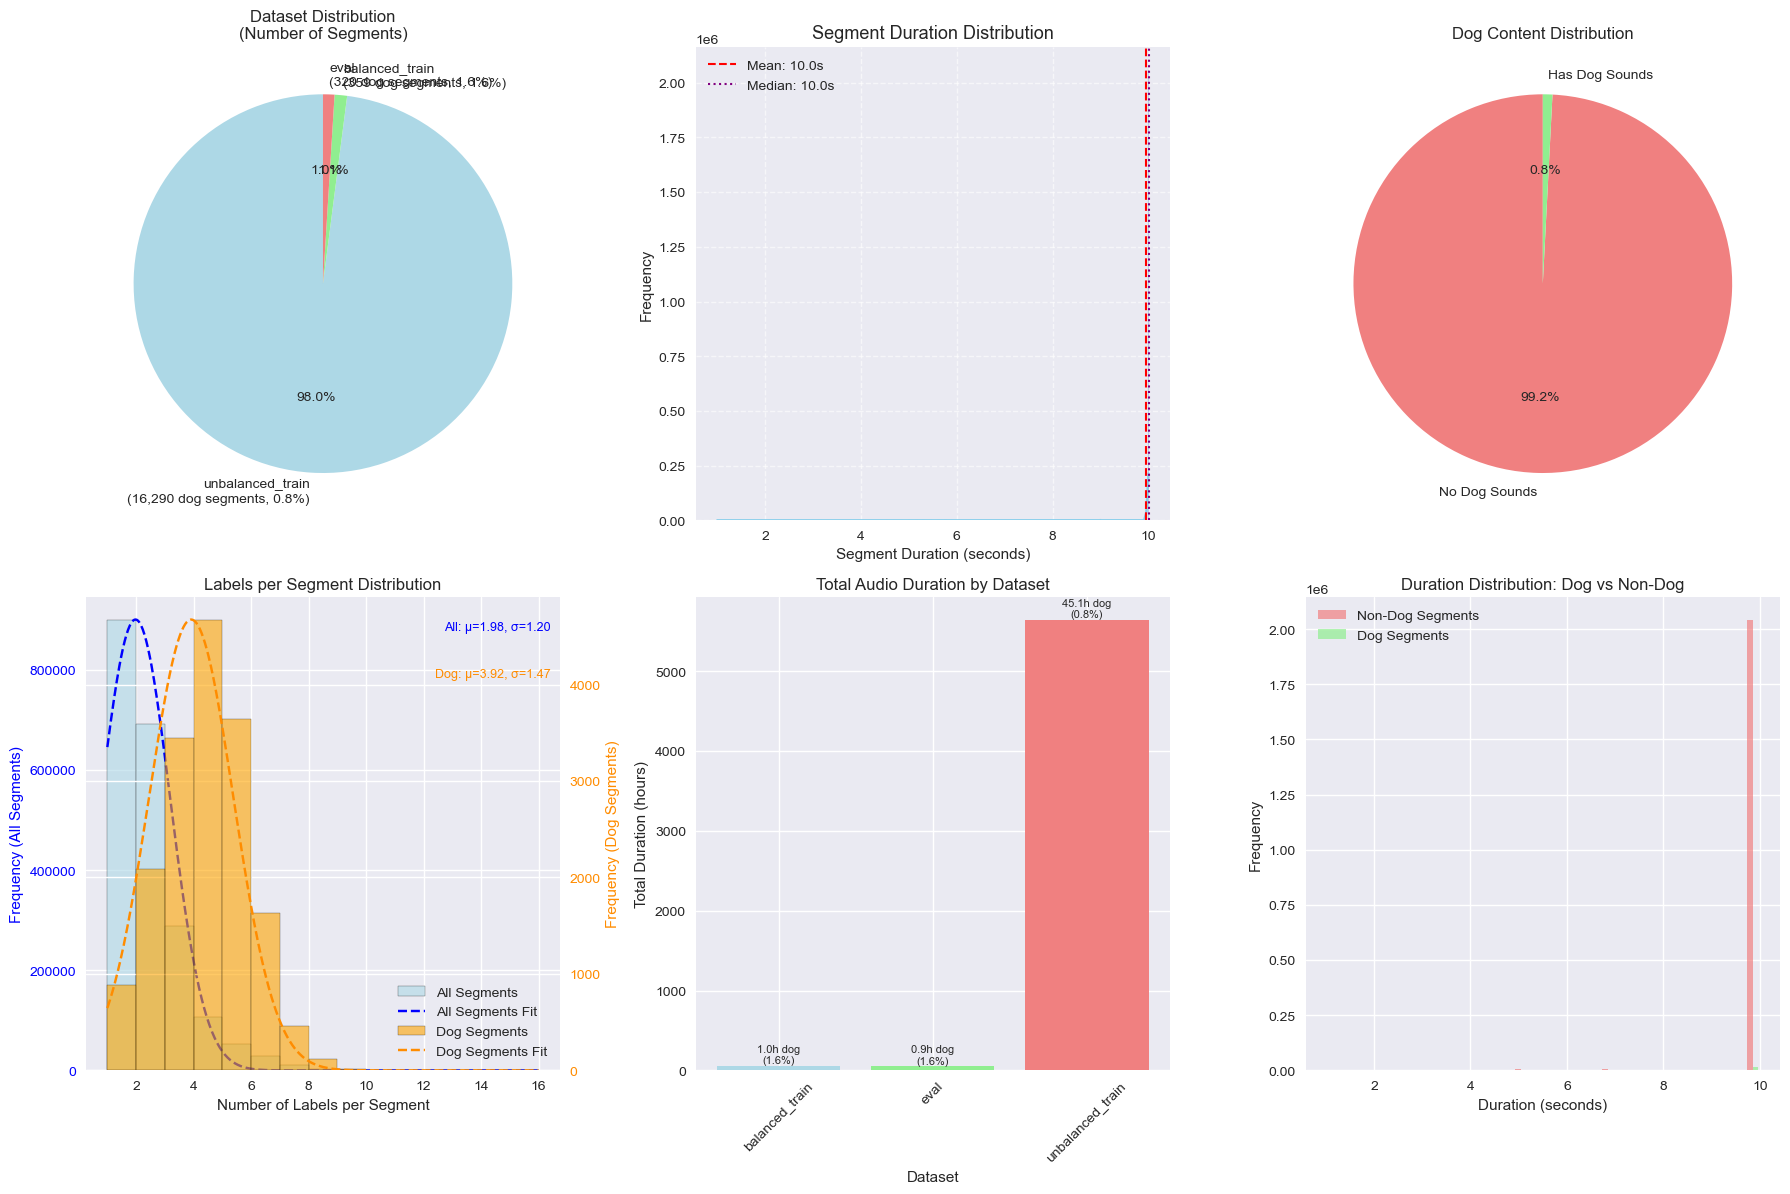


Detailed Statistics (Enhanced with Ontology):
--------------------------------------------------
Total segments: 2,084,320
Segments with dog sounds: 16,969 (0.8%)
Segments with specific dog vocalizations: 9,429
Unique videos: 2,084,320
Total audio duration: 5765.4 hours
Dog audio duration: 46.9 hours

Duration Statistics:
  Average segment duration: 9.96 seconds
  Average dog segment duration: 9.96 seconds
  Median segment duration: 10.00 seconds
  Duration range: 1.0 - 10.0 seconds

Labels per segment:
  Average (all): 1.98
  Average (dog segments): 3.92
  Average dog labels per dog segment: 1.53

Dataset breakdown:
  balanced_train: 22,160 segments, 61.2 hours
    Dog content: 359 segments (1.6%), 1.0 hours
  unbalanced_train: 2,041,789 segments, 5647.9 hours
    Dog content: 16,290 segments (0.8%), 45.1 hours
  eval: 20,371 segments, 56.2 hours
    Dog content: 320 segments (1.6%), 0.9 hours


In [5]:
# Basic statistics and data quality analysis with ontology-enhanced labels
print("AudioSet Dog Data - Basic Statistics (with Ontology)")
print("=" * 60)

# Dataset overview with dog-specific insights
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Dataset distribution with dog content breakdown
dataset_counts = combined_df['dataset'].value_counts()
colors = ['lightblue', 'lightgreen', 'lightcoral']
wedges, texts, autotexts = axes[0, 0].pie(dataset_counts.values, labels=dataset_counts.index, 
                                          autopct='%1.1f%%', startangle=90, colors=colors)
axes[0, 0].set_title('Dataset Distribution\n(Number of Segments)')

# Add dog content info as text
dog_by_dataset = combined_df.groupby('dataset')['has_dog_sounds'].sum()
for i, dataset in enumerate(dataset_counts.index):
    dog_count = dog_by_dataset.get(dataset, 0)
    dog_pct = (dog_count / dataset_counts[dataset]) * 100
    texts[i].set_text(f'{dataset}\n({dog_count:,} dog segments, {dog_pct:.1f}%)')

# 2. Duration distribution
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# Cleaned-up Segment Duration Distribution
ax_duration = axes[0, 1]

# Plot histogram with KDE overlay using seaborn
sns.histplot(combined_df['duration'], bins='sqrt', kde=True, ax=ax_duration, color='skyblue', edgecolor='black')

# Mean and median
mean_duration = combined_df['duration'].mean()
median_duration = combined_df['duration'].median()

# Vertical lines for mean and median
ax_duration.axvline(mean_duration, color='red', linestyle='--', linewidth=1.5, label=f'Mean: {mean_duration:.1f}s')
ax_duration.axvline(median_duration, color='purple', linestyle=':', linewidth=1.5, label=f'Median: {median_duration:.1f}s')

# Axis labels and title
ax_duration.set_xlabel('Segment Duration (seconds)', fontsize=11)
ax_duration.set_ylabel('Frequency', fontsize=11)
ax_duration.set_title('Segment Duration Distribution', fontsize=13)

# Grid for readability
ax_duration.grid(True, linestyle='--', alpha=0.6)

# Optional: log-scale if duration is heavily skewed
# ax_duration.set_xscale('log')
# ax_duration.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:g}'))

# Legend
ax_duration.legend()

# 3. Dog content distribution
dog_content_counts = combined_df['has_dog_sounds'].value_counts()
dog_labels = ['No Dog Sounds', 'Has Dog Sounds']
colors_dog = ['lightcoral', 'lightgreen']
axes[0, 2].pie(dog_content_counts.values, labels=dog_labels, autopct='%1.1f%%', 
               startangle=90, colors=colors_dog)
axes[0, 2].set_title('Dog Content Distribution')

# 4. Number of labels per segment (overall vs dog segments)
from scipy.stats import norm
import numpy as np

# Primary y-axis: All Segments
ax_main = axes[1, 0]
bins = range(1, combined_df['num_labels'].max() + 2)
bin_centers = np.array(bins[:-1]) + 0.5

# Histogram for All Segments
n_all, _, _ = ax_main.hist(combined_df['num_labels'], bins=bins, alpha=0.6,
                           edgecolor='black', label='All Segments', color='lightblue')
ax_main.set_ylabel('Frequency (All Segments)', color='blue')
ax_main.tick_params(axis='y', labelcolor='blue')

# Fit Gaussian for All Segments
mean_all = combined_df['num_labels'].mean()
std_all = combined_df['num_labels'].std()
x_vals = np.linspace(min(bins), max(bins), 500)
y_all_pdf = norm.pdf(x_vals, mean_all, std_all)
y_all_scaled = y_all_pdf * np.max(n_all) / np.max(y_all_pdf)  # Scale to histogram height
ax_main.plot(x_vals, y_all_scaled, color='blue', linestyle='--', label='All Segments Fit')
ax_main.text(0.98, 0.95, f'All: μ={mean_all:.2f}, σ={std_all:.2f}', 
             transform=ax_main.transAxes, ha='right', va='top', color='blue', fontsize=9)

# Secondary y-axis: Dog Segments
ax_dog = ax_main.twinx()
dog_segments = combined_df[combined_df['has_dog_sounds']]
if len(dog_segments) > 0:
    n_dog, _, _ = ax_dog.hist(dog_segments['num_labels'], bins=bins, alpha=0.6,
                              edgecolor='black', label='Dog Segments', color='orange')

    # Fit Gaussian for Dog Segments
    mean_dog = dog_segments['num_labels'].mean()
    std_dog = dog_segments['num_labels'].std()
    y_dog_pdf = norm.pdf(x_vals, mean_dog, std_dog)
    y_dog_scaled = y_dog_pdf * np.max(n_dog) / np.max(y_dog_pdf)
    ax_dog.plot(x_vals, y_dog_scaled, color='darkorange', linestyle='--', label='Dog Segments Fit')
    ax_dog.text(0.98, 0.85, f'Dog: μ={mean_dog:.2f}, σ={std_dog:.2f}', 
                transform=ax_main.transAxes, ha='right', va='top', color='darkorange', fontsize=9)

    ax_dog.set_ylabel('Frequency (Dog Segments)', color='darkorange')
    ax_dog.tick_params(axis='y', labelcolor='darkorange')

# Common settings
ax_main.set_xlabel('Number of Labels per Segment')
ax_main.set_title('Labels per Segment Distribution')

# Combined Legend
lines_main, labels_main = ax_main.get_legend_handles_labels()
lines_dog, labels_dog = ax_dog.get_legend_handles_labels() if len(dog_segments) > 0 else ([], [])
ax_main.legend(lines_main + lines_dog, labels_main + labels_dog)

# 5. Total duration by dataset
duration_by_dataset = combined_df.groupby('dataset')['duration'].sum() / 3600  # Convert to hours
bars = axes[1, 1].bar(duration_by_dataset.index, duration_by_dataset.values, color=['lightblue', 'lightgreen', 'lightcoral'])
axes[1, 1].set_xlabel('Dataset')
axes[1, 1].set_ylabel('Total Duration (hours)')
axes[1, 1].set_title('Total Audio Duration by Dataset')
axes[1, 1].tick_params(axis='x', rotation=45)

# Add dog duration as text on bars
dog_duration_by_dataset = combined_df[combined_df['has_dog_sounds']].groupby('dataset')['duration'].sum() / 3600
for i, (dataset, bar) in enumerate(zip(duration_by_dataset.index, bars)):
    dog_hours = dog_duration_by_dataset.get(dataset, 0)
    dog_pct = (dog_hours / duration_by_dataset[dataset]) * 100 if duration_by_dataset[dataset] > 0 else 0
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.5,
                    f'{dog_hours:.1f}h dog\n({dog_pct:.1f}%)', ha='center', va='bottom', fontsize=8)

# 6. Dog vs non-dog segment durations
dog_durations = combined_df[combined_df['has_dog_sounds']]['duration']
non_dog_durations = combined_df[~combined_df['has_dog_sounds']]['duration']

axes[1, 2].hist([non_dog_durations, dog_durations], bins=30, alpha=0.7, 
                label=['Non-Dog Segments', 'Dog Segments'], color=['lightcoral', 'lightgreen'])
axes[1, 2].set_xlabel('Duration (seconds)')
axes[1, 2].set_ylabel('Frequency')
axes[1, 2].set_title('Duration Distribution: Dog vs Non-Dog')
axes[1, 2].legend()

plt.tight_layout()
plt.show()

# Detailed statistics with ontology information
print("\nDetailed Statistics (Enhanced with Ontology):")
print("-" * 50)
print(f"Total segments: {len(combined_df):,}")
print(f"Segments with dog sounds: {combined_df['has_dog_sounds'].sum():,} ({combined_df['has_dog_sounds'].mean()*100:.1f}%)")
print(f"Segments with specific dog vocalizations: {(combined_df['num_specific_dog_labels'] > 0).sum():,}")
print(f"Unique videos: {combined_df['ytid'].nunique():,}")
print(f"Total audio duration: {combined_df['duration'].sum()/3600:.1f} hours")
print(f"Dog audio duration: {combined_df[combined_df['has_dog_sounds']]['duration'].sum()/3600:.1f} hours")

print(f"\nDuration Statistics:")
print(f"  Average segment duration: {combined_df['duration'].mean():.2f} seconds")
print(f"  Average dog segment duration: {dog_durations.mean():.2f} seconds" if len(dog_durations) > 0 else "  No dog segments")
print(f"  Median segment duration: {combined_df['duration'].median():.2f} seconds")
print(f"  Duration range: {combined_df['duration'].min():.1f} - {combined_df['duration'].max():.1f} seconds")

print(f"\nLabels per segment:")
print(f"  Average (all): {combined_df['num_labels'].mean():.2f}")
print(f"  Average (dog segments): {dog_segments['num_labels'].mean():.2f}" if len(dog_segments) > 0 else "  No dog segments")
print(f"  Average dog labels per dog segment: {dog_segments['num_dog_labels'].mean():.2f}" if len(dog_segments) > 0 else "  No dog segments")

print(f"\nDataset breakdown:")
for dataset in combined_df['dataset'].unique():
    subset = combined_df[combined_df['dataset'] == dataset]
    dog_subset = subset[subset['has_dog_sounds']]
    duration_hours = subset['duration'].sum() / 3600
    dog_duration_hours = dog_subset['duration'].sum() / 3600
    print(f"  {dataset}: {len(subset):,} segments, {duration_hours:.1f} hours")
    print(f"    Dog content: {len(dog_subset):,} segments ({len(dog_subset)/len(subset)*100:.1f}%), {dog_duration_hours:.1f} hours")


### Dog-Specific Sound Analysis

Now let's dive deep into the dog-specific sounds using the ontology hierarchy. We'll analyze the distribution of different dog vocalizations and their characteristics.


🐕 DOG-SPECIFIC SOUND ANALYSIS
Analyzing 16,969 dog-related segments...


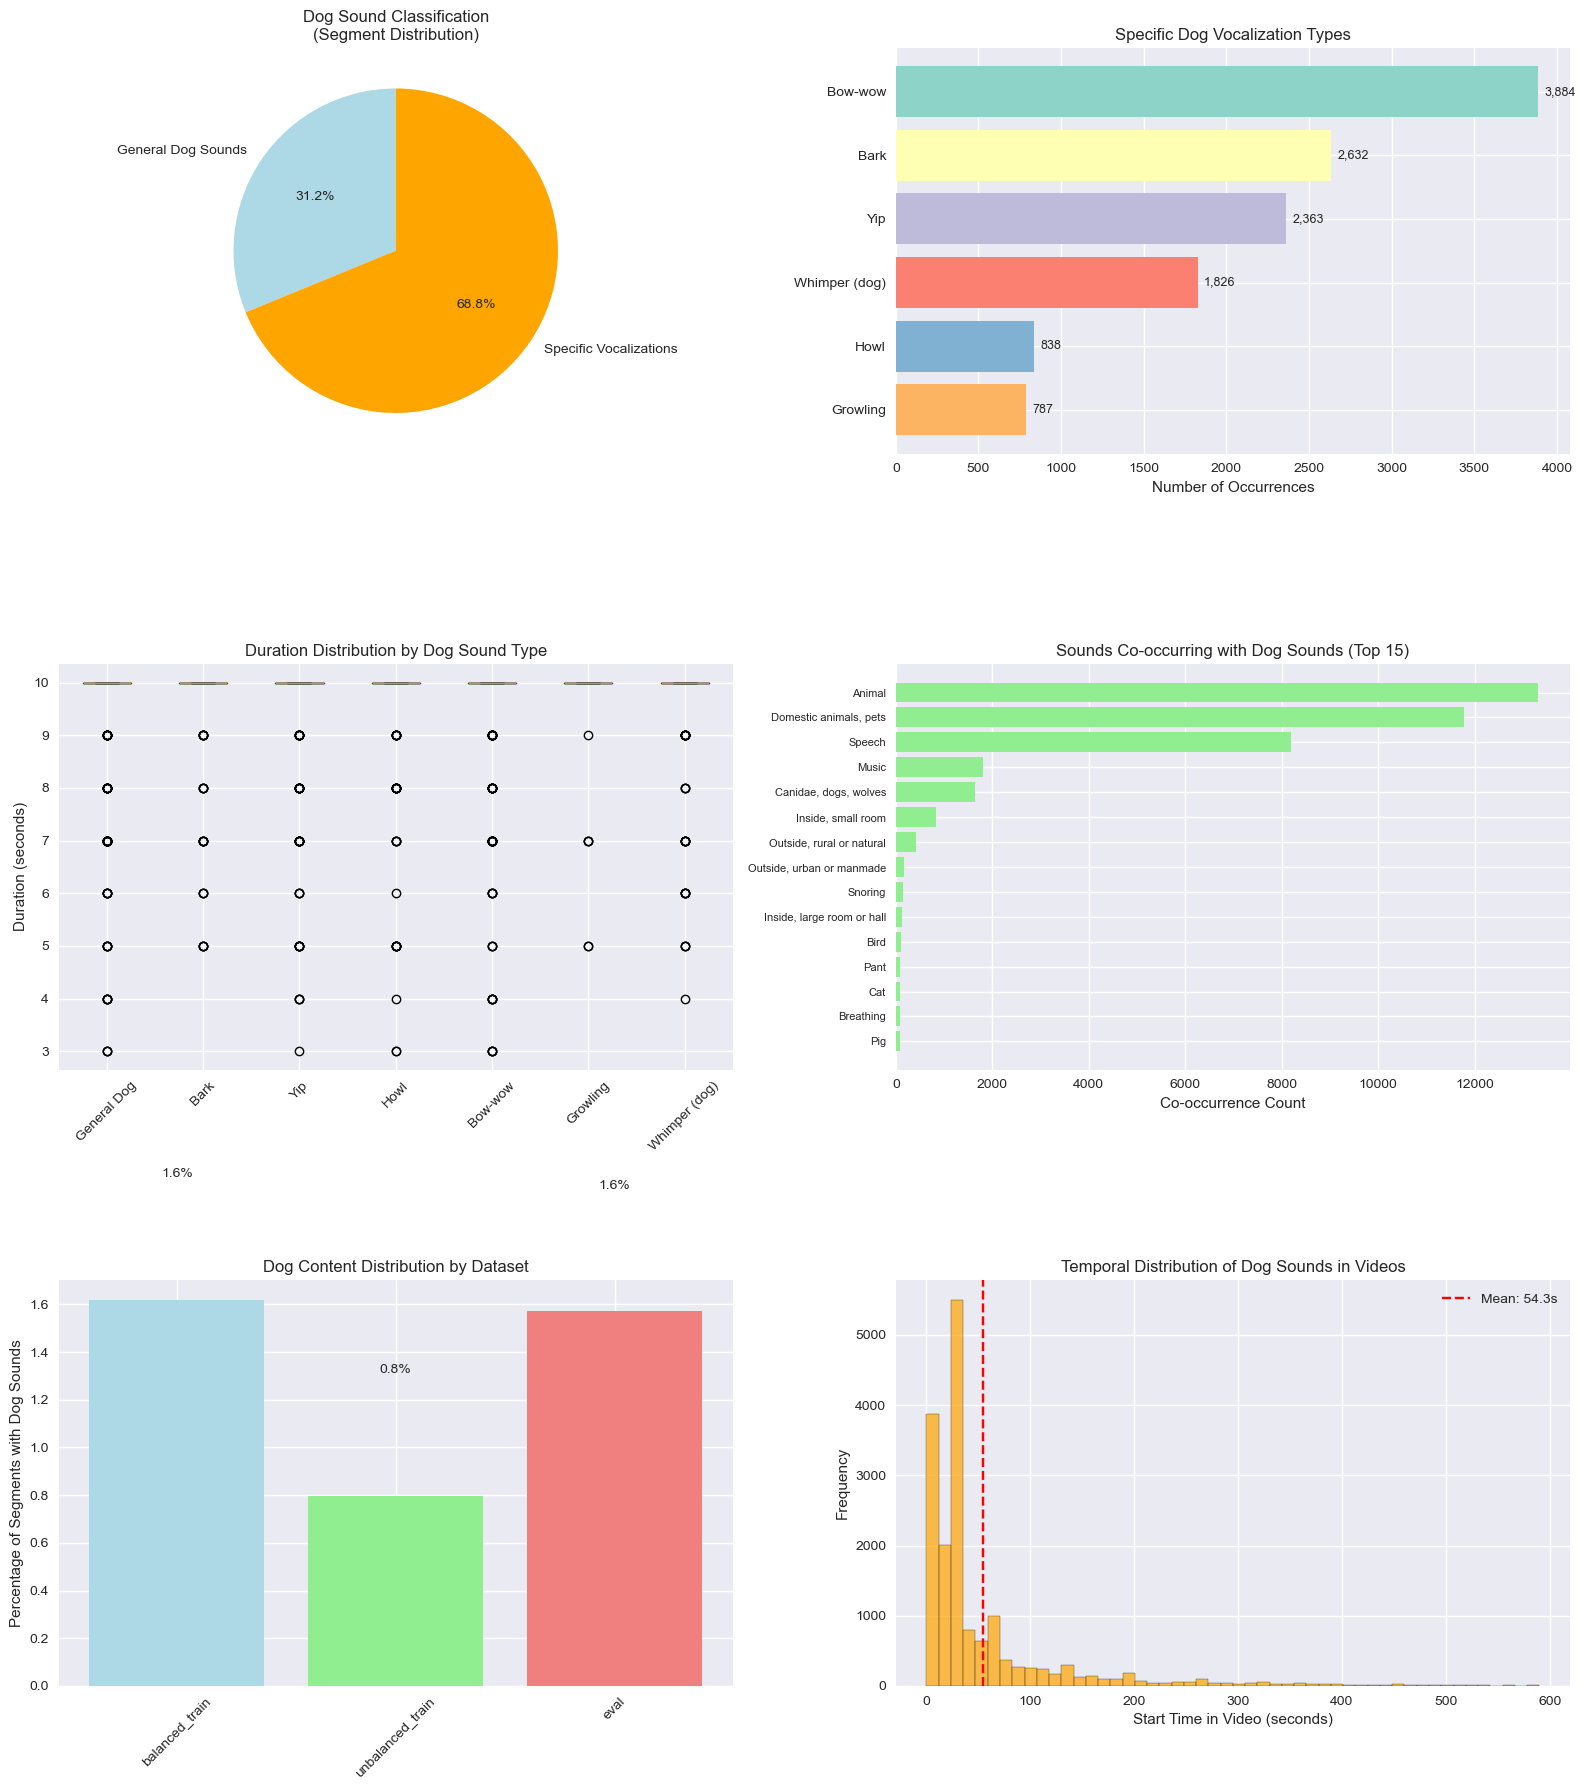


🔍 DETAILED DOG SOUND STATISTICS:
----------------------------------------
Total dog-related segments: 16,969
Total dog sound instances: 26,035
Unique dog sound types: 7

📊 Dog Sound Distribution:
  Dog: 13,705 (52.6%)
  Bow-wow: 3,884 (14.9%)
  Bark: 2,632 (10.1%)
  Yip: 2,363 (9.1%)
  Whimper (dog): 1,826 (7.0%)
  Howl: 838 (3.2%)
  Growling: 787 (3.0%)

🗣️ Specific Dog Vocalizations:
  Bow-wow: 3,884 (31.5%)
    Description: Dog communication sound that is more tonal and less abrupt than a classic bark.
  Bark: 2,632 (21.3%)
    Description: Principal communication sound produced by dogs. Often transliterated as woof, especially for large d...
  Yip: 2,363 (19.2%)
    Description: A sharp high-pitched bark or cry, typically from a miniature dog.
  Whimper (dog): 1,826 (14.8%)
    Description: Muted dog vocalization indicating submission, fear, or pain.
  Howl: 838 (6.8%)
    Description: The long plaintive cry of a dog, wolf, or other canidae.
  Growling: 787 (6.4%)
    Description:

In [6]:
# Comprehensive analysis of dog-specific sounds using ontology
print("🐕 DOG-SPECIFIC SOUND ANALYSIS")
print("=" * 50)

# Filter to only dog-related segments
dog_segments = combined_df[combined_df['has_dog_sounds']].copy()

if len(dog_segments) == 0:
    print("❌ No dog segments found in the dataset!")
else:
    print(f"Analyzing {len(dog_segments):,} dog-related segments...")
    
    # Flatten all dog labels from all segments
    all_dog_labels = []
    all_specific_dog_labels = []
    
    for _, row in dog_segments.iterrows():
        all_dog_labels.extend(row['dog_labels'])
        all_specific_dog_labels.extend(row['specific_dog_labels'])
    
    # Count occurrences
    dog_label_counts = Counter(all_dog_labels)
    specific_dog_counts = Counter(all_specific_dog_labels)
    
    # Create comprehensive analysis
    fig, axes = plt.subplots(3, 2, figsize=(16, 18))
    
    # 1. Overall dog sound hierarchy
    # Count segments containing the main "Dog" category vs specific vocalizations
    main_dog_segments = len(dog_segments[dog_segments['dog_labels'].apply(lambda x: "/m/0bt9lr" in x)])
    specific_vocal_segments = len(dog_segments[dog_segments['num_specific_dog_labels'] > 0])
    
    hierarchy_data = [main_dog_segments - specific_vocal_segments, specific_vocal_segments]
    hierarchy_labels = ['General Dog Sounds', 'Specific Vocalizations']
    
    axes[0, 0].pie(hierarchy_data, labels=hierarchy_labels, autopct='%1.1f%%', startangle=90,
                   colors=['lightblue', 'orange'])
    axes[0, 0].set_title('Dog Sound Classification\n(Segment Distribution)')
    
    # 2. Specific dog vocalization types
    if specific_dog_counts:
        # Get top specific dog sounds
        top_specific = dict(sorted(specific_dog_counts.items(), key=lambda x: x[1], reverse=True))
        
        # Map to readable names
        specific_names = [ontology_data['id_to_name'].get(label_id, label_id) for label_id in top_specific.keys()]
        specific_counts = list(top_specific.values())
        
        bars = axes[0, 1].barh(range(len(specific_names)), specific_counts, 
                               color=plt.cm.Set3(range(len(specific_names))))
        axes[0, 1].set_yticks(range(len(specific_names)))
        axes[0, 1].set_yticklabels(specific_names, fontsize=10)
        axes[0, 1].set_xlabel('Number of Occurrences')
        axes[0, 1].set_title('Specific Dog Vocalization Types')
        axes[0, 1].invert_yaxis()
        
        # Add count labels on bars
        for i, (bar, count) in enumerate(zip(bars, specific_counts)):
            axes[0, 1].text(bar.get_width() + max(specific_counts)*0.01, bar.get_y() + bar.get_height()/2,
                            f'{count:,}', ha='left', va='center', fontsize=9)
    
    # 3. Duration analysis by dog sound type
    duration_by_type = {}
    
    # General dog sounds (not specific vocalizations)
    general_dog_segs = dog_segments[
        (dog_segments['dog_labels'].apply(lambda x: "/m/0bt9lr" in x)) &
        (dog_segments['num_specific_dog_labels'] == 0)
    ]
    if len(general_dog_segs) > 0:
        duration_by_type['General Dog'] = general_dog_segs['duration'].tolist()
    
    # Specific vocalizations
    for dog_sound_id in ontology_data['dog_child_ids']:
        sound_name = ontology_data['id_to_name'].get(dog_sound_id, dog_sound_id)
        sound_segments = dog_segments[
            dog_segments['specific_dog_labels'].apply(lambda x: dog_sound_id in x)
        ]
        if len(sound_segments) > 0:
            duration_by_type[sound_name] = sound_segments['duration'].tolist()
    
    # Plot duration distributions
    if duration_by_type:
        durations_list = list(duration_by_type.values())
        labels_list = list(duration_by_type.keys())
        
        axes[1, 0].boxplot(durations_list, labels=labels_list)
        axes[1, 0].set_ylabel('Duration (seconds)')
        axes[1, 0].set_title('Duration Distribution by Dog Sound Type')
        axes[1, 0].tick_params(axis='x', rotation=45)
    
    # 4. Co-occurrence analysis of dog sounds with other labels
    # Find what other sounds commonly occur with dog sounds
    other_labels_with_dogs = []
    for _, row in dog_segments.iterrows():
        # Get non-dog labels in segments that have dog sounds
        non_dog_labels = [label for label in row['positive_labels'] 
                         if label not in ontology_data['all_dog_sounds']]
        other_labels_with_dogs.extend(non_dog_labels)
    
    other_label_counts = Counter(other_labels_with_dogs)
    
    if other_label_counts:
        # Get top 15 co-occurring labels
        top_cooccur = dict(sorted(other_label_counts.items(), key=lambda x: x[1], reverse=True)[:15])
        cooccur_names = [ontology_data['id_to_name'].get(label_id, label_id) for label_id in top_cooccur.keys()]
        cooccur_counts = list(top_cooccur.values())
        
        axes[1, 1].barh(range(len(cooccur_names)), cooccur_counts, color='lightgreen')
        axes[1, 1].set_yticks(range(len(cooccur_names)))
        axes[1, 1].set_yticklabels(cooccur_names, fontsize=8)
        axes[1, 1].set_xlabel('Co-occurrence Count')
        axes[1, 1].set_title('Sounds Co-occurring with Dog Sounds (Top 15)')
        axes[1, 1].invert_yaxis()
    
    # 5. Dog sound frequency by dataset
    dataset_dog_analysis = {}
    for dataset in combined_df['dataset'].unique():
        dataset_segments = combined_df[combined_df['dataset'] == dataset]
        dataset_dog_segments = dataset_segments[dataset_segments['has_dog_sounds']]
        
        dataset_dog_analysis[dataset] = {
            'total_segments': len(dataset_segments),
            'dog_segments': len(dataset_dog_segments),
            'dog_percentage': len(dataset_dog_segments) / len(dataset_segments) * 100 if len(dataset_segments) > 0 else 0,
            'avg_dog_labels_per_segment': dataset_dog_segments['num_dog_labels'].mean() if len(dataset_dog_segments) > 0 else 0
        }
    
    datasets = list(dataset_dog_analysis.keys())
    dog_percentages = [dataset_dog_analysis[d]['dog_percentage'] for d in datasets]
    
    bars = axes[2, 0].bar(datasets, dog_percentages, color=['lightblue', 'lightgreen', 'lightcoral'])
    axes[2, 0].set_ylabel('Percentage of Segments with Dog Sounds')
    axes[2, 0].set_title('Dog Content Distribution by Dataset')
    axes[2, 0].tick_params(axis='x', rotation=45)
    
    # Add percentage labels on bars
    for bar, pct in zip(bars, dog_percentages):
        axes[2, 0].text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.5,
                        f'{pct:.1f}%', ha='center', va='bottom')
    
    # 6. Temporal patterns of dog sounds
    # Analyze if dog sounds appear at certain times in videos
    dog_start_times = dog_segments['start_seconds']
    
    axes[2, 1].hist(dog_start_times, bins=50, alpha=0.7, color='orange', edgecolor='black')
    axes[2, 1].set_xlabel('Start Time in Video (seconds)')
    axes[2, 1].set_ylabel('Frequency')
    axes[2, 1].set_title('Temporal Distribution of Dog Sounds in Videos')
    axes[2, 1].axvline(dog_start_times.mean(), color='red', linestyle='--',
                       label=f'Mean: {dog_start_times.mean():.1f}s')
    axes[2, 1].legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed dog sound statistics
    print(f"\n🔍 DETAILED DOG SOUND STATISTICS:")
    print("-" * 40)
    print(f"Total dog-related segments: {len(dog_segments):,}")
    print(f"Total dog sound instances: {len(all_dog_labels):,}")
    print(f"Unique dog sound types: {len(set(all_dog_labels))}")
    
    print(f"\n📊 Dog Sound Distribution:")
    for label_id, count in sorted(dog_label_counts.items(), key=lambda x: x[1], reverse=True):
        label_name = ontology_data['id_to_name'].get(label_id, label_id)
        percentage = (count / len(all_dog_labels)) * 100
        print(f"  {label_name}: {count:,} ({percentage:.1f}%)")
    
    if specific_dog_counts:
        print(f"\n🗣️ Specific Dog Vocalizations:")
        for label_id, count in sorted(specific_dog_counts.items(), key=lambda x: x[1], reverse=True):
            label_name = ontology_data['id_to_name'].get(label_id, label_id)
            # Get description
            label_info = ontology_data['id_to_info'].get(label_id, {})
            description = label_info.get('description', 'No description')
            percentage = (count / len(all_specific_dog_labels)) * 100 if all_specific_dog_labels else 0
            print(f"  {label_name}: {count:,} ({percentage:.1f}%)")
            print(f"    Description: {description[:100]}{'...' if len(description) > 100 else ''}")
    
    print(f"\n⏱️ Timing Statistics:")
    print(f"  Average dog segment duration: {dog_segments['duration'].mean():.2f} seconds")
    print(f"  Median dog segment duration: {dog_segments['duration'].median():.2f} seconds")
    print(f"  Average start time: {dog_segments['start_seconds'].mean():.1f} seconds")
    print(f"  Most common start time range: {dog_segments['start_seconds'].mode().iloc[0]:.0f}s" if len(dog_segments['start_seconds'].mode()) > 0 else "  No clear pattern")
    
    print(f"\n📈 Dataset Comparison:")
    for dataset, stats in dataset_dog_analysis.items():
        print(f"  {dataset}:")
        print(f"    Dog segments: {stats['dog_segments']:,} / {stats['total_segments']:,} ({stats['dog_percentage']:.1f}%)")
        print(f"    Avg dog labels per dog segment: {stats['avg_dog_labels_per_segment']:.2f}")

# Create a summary of the ontology-based improvements
print(f"\n✨ ONTOLOGY-ENHANCED INSIGHTS:")
print("-" * 35)
print("✅ Improvements from using ontology.json:")
print("  • Precise label name mapping (no more manual parsing)")
print("  • Hierarchical understanding of dog sound relationships") 
print("  • Automated identification of dog-specific vs general sounds")
print("  • Rich descriptions for each sound type")
print("  • Comprehensive analysis of vocalization patterns")
print("  • Better co-occurrence analysis with proper label filtering")


### Label Distribution Analysis

Let's analyze the overall label distribution using the ontology for better presentation.


Label Distribution Analysis (with Ontology)
Total unique labels: 527
Total label instances: 4124898


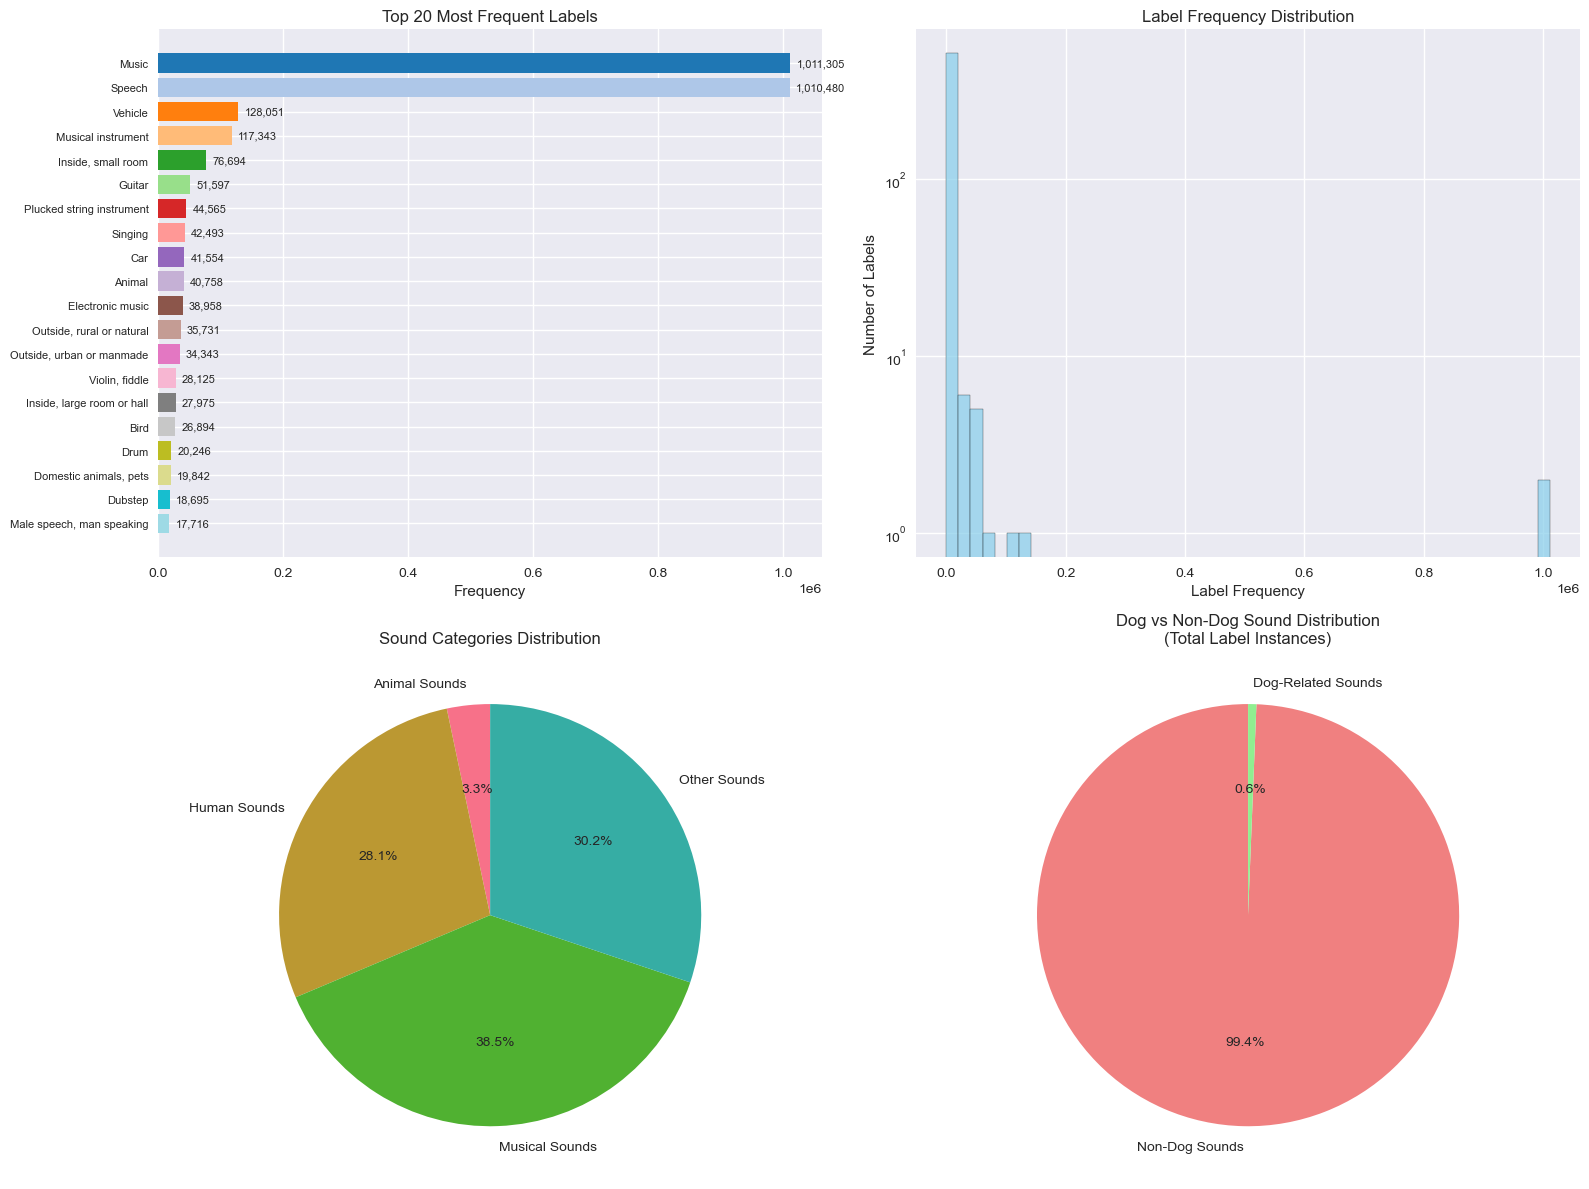


📊 CATEGORY BREAKDOWN:
------------------------------

🐕 Animal Sounds: 136,003 instances (3.3%)
  Animal: 40,758 (30.0% of category)
  Bird: 26,894 (19.8% of category)
  Domestic animals, pets: 19,842 (14.6% of category)
  Dog: 13,705 (10.1% of category)
  Fowl: 6,248 (4.6% of category)

🗣️ Human Sounds: 1,157,748 instances (28.1%)
  Speech: 1,010,480 (87.3% of category)
  Singing: 42,493 (3.7% of category)
  Male speech, man speaking: 17,716 (1.5% of category)
  Narration, monologue: 15,590 (1.3% of category)
  Child speech, kid speaking: 11,816 (1.0% of category)

🎵 Musical Sounds: 1,586,985 instances (38.5%)
  Music: 1,011,305 (63.7% of category)
  Musical instrument: 117,343 (7.4% of category)
  Plucked string instrument: 44,565 (2.8% of category)
  Electronic music: 38,958 (2.5% of category)
  Dubstep: 18,695 (1.2% of category)

🔊 Other Sounds: 1,244,162 instances (30.2%)
  Vehicle: 128,051 (10.3% of category)
  Inside, small room: 76,694 (6.2% of category)
  Guitar: 51,597 (4.1%

In [7]:
# Analyze overall label distributions using ontology
print("Label Distribution Analysis (with Ontology)")
print("=" * 50)

# Flatten all labels and count occurrences
all_labels = []
for labels_list in combined_df['positive_labels']:
    all_labels.extend(labels_list)

label_counts = Counter(all_labels)

# Map label IDs to names using ontology
label_counts_named = {}
for label_id, count in label_counts.items():
    label_name = ontology_data['id_to_name'].get(label_id, f"Unknown ({label_id})")
    label_counts_named[label_name] = count

# Sort by frequency
sorted_labels = sorted(label_counts_named.items(), key=lambda x: x[1], reverse=True)

print(f"Total unique labels: {len(label_counts)}")
print(f"Total label instances: {sum(label_counts.values())}")

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Top 20 most frequent labels (with proper names)
top_20_labels = sorted_labels[:20]
labels_20, counts_20 = zip(*top_20_labels)
bars = axes[0, 0].barh(range(len(labels_20)), counts_20, color=plt.cm.tab20(range(len(labels_20))))
axes[0, 0].set_yticks(range(len(labels_20)))
axes[0, 0].set_yticklabels(labels_20, fontsize=8)
axes[0, 0].set_xlabel('Frequency')
axes[0, 0].set_title('Top 20 Most Frequent Labels')
axes[0, 0].invert_yaxis()

# Add count labels
for i, (bar, count) in enumerate(zip(bars, counts_20)):
    axes[0, 0].text(bar.get_width() + max(counts_20)*0.01, bar.get_y() + bar.get_height()/2,
                    f'{count:,}', ha='left', va='center', fontsize=8)

# 2. Label frequency distribution (log scale)
frequencies = list(label_counts.values())
axes[0, 1].hist(frequencies, bins=50, alpha=0.7, edgecolor='black', color='skyblue')
axes[0, 1].set_xlabel('Label Frequency')
axes[0, 1].set_ylabel('Number of Labels')
axes[0, 1].set_title('Label Frequency Distribution')
axes[0, 1].set_yscale('log')

# 3. Animal vs non-animal sounds breakdown
animal_labels = []
human_labels = []
music_labels = []
other_labels = []

# Categorize labels based on ontology hierarchy
for label_id, count in label_counts.items():
    label_name = ontology_data['id_to_name'].get(label_id, label_id)
    
    # Use ontology to find parent categories
    parents = ontology_data['child_to_parents'].get(label_id, [])
    parent_names = [ontology_data['id_to_name'].get(p, p) for p in parents]
    
    # Categorize based on name and hierarchy
    if any('animal' in name.lower() for name in [label_name] + parent_names):
        animal_labels.append((label_name, count))
    elif any('human' in name.lower() or 'voice' in name.lower() or 'speech' in name.lower() 
             for name in [label_name] + parent_names):
        human_labels.append((label_name, count))
    elif any('music' in name.lower() or 'musical' in name.lower() 
             for name in [label_name] + parent_names):
        music_labels.append((label_name, count))
    else:
        other_labels.append((label_name, count))

# Create category summary
category_counts = {
    'Animal Sounds': sum(count for _, count in animal_labels),
    'Human Sounds': sum(count for _, count in human_labels),
    'Musical Sounds': sum(count for _, count in music_labels),
    'Other Sounds': sum(count for _, count in other_labels)
}

axes[1, 0].pie(category_counts.values(), labels=category_counts.keys(), 
               autopct='%1.1f%%', startangle=90)
axes[1, 0].set_title('Sound Categories Distribution')

# 4. Dog sounds in context - showing how prominent dog sounds are
dog_sound_total = sum(count for label_id, count in label_counts.items() 
                     if label_id in ontology_data['all_dog_sounds'])
non_dog_total = sum(label_counts.values()) - dog_sound_total

context_data = [non_dog_total, dog_sound_total]
context_labels = ['Non-Dog Sounds', 'Dog-Related Sounds']
colors = ['lightcoral', 'lightgreen']

axes[1, 1].pie(context_data, labels=context_labels, autopct='%1.1f%%', 
               startangle=90, colors=colors)
axes[1, 1].set_title('Dog vs Non-Dog Sound Distribution\n(Total Label Instances)')

plt.tight_layout()
plt.show()

# Print detailed category breakdowns
print(f"\n📊 CATEGORY BREAKDOWN:")
print("-" * 30)

categories = [
    ("🐕 Animal Sounds", animal_labels),
    ("🗣️ Human Sounds", human_labels), 
    ("🎵 Musical Sounds", music_labels),
    ("🔊 Other Sounds", other_labels)
]

for category_name, category_labels in categories:
    total_count = sum(count for _, count in category_labels)
    percentage = (total_count / sum(label_counts.values())) * 100
    print(f"\n{category_name}: {total_count:,} instances ({percentage:.1f}%)")
    
    # Show top 5 in each category
    top_in_category = sorted(category_labels, key=lambda x: x[1], reverse=True)[:5]
    for label_name, count in top_in_category:
        pct_in_category = (count / total_count) * 100 if total_count > 0 else 0
        print(f"  {label_name}: {count:,} ({pct_in_category:.1f}% of category)")

# Special focus on dog sound context
print(f"\n🐕 DOG SOUNDS IN CONTEXT:")
print("-" * 25)
print(f"Total label instances in dataset: {sum(label_counts.values()):,}")
print(f"Dog-related sound instances: {dog_sound_total:,} ({dog_sound_total/sum(label_counts.values())*100:.1f}%)")

dog_labels_detail = [(ontology_data['id_to_name'].get(label_id, label_id), count) 
                    for label_id, count in label_counts.items() 
                    if label_id in ontology_data['all_dog_sounds']]
dog_labels_detail.sort(key=lambda x: x[1], reverse=True)

print(f"Breakdown of dog-related sounds:")
for label_name, count in dog_labels_detail:
    percentage = (count / dog_sound_total) * 100 if dog_sound_total > 0 else 0
    print(f"  {label_name}: {count:,} ({percentage:.1f}% of dog sounds)")


### Temporal Analysis


Temporal Analysis (Enhanced for Dog Sounds)


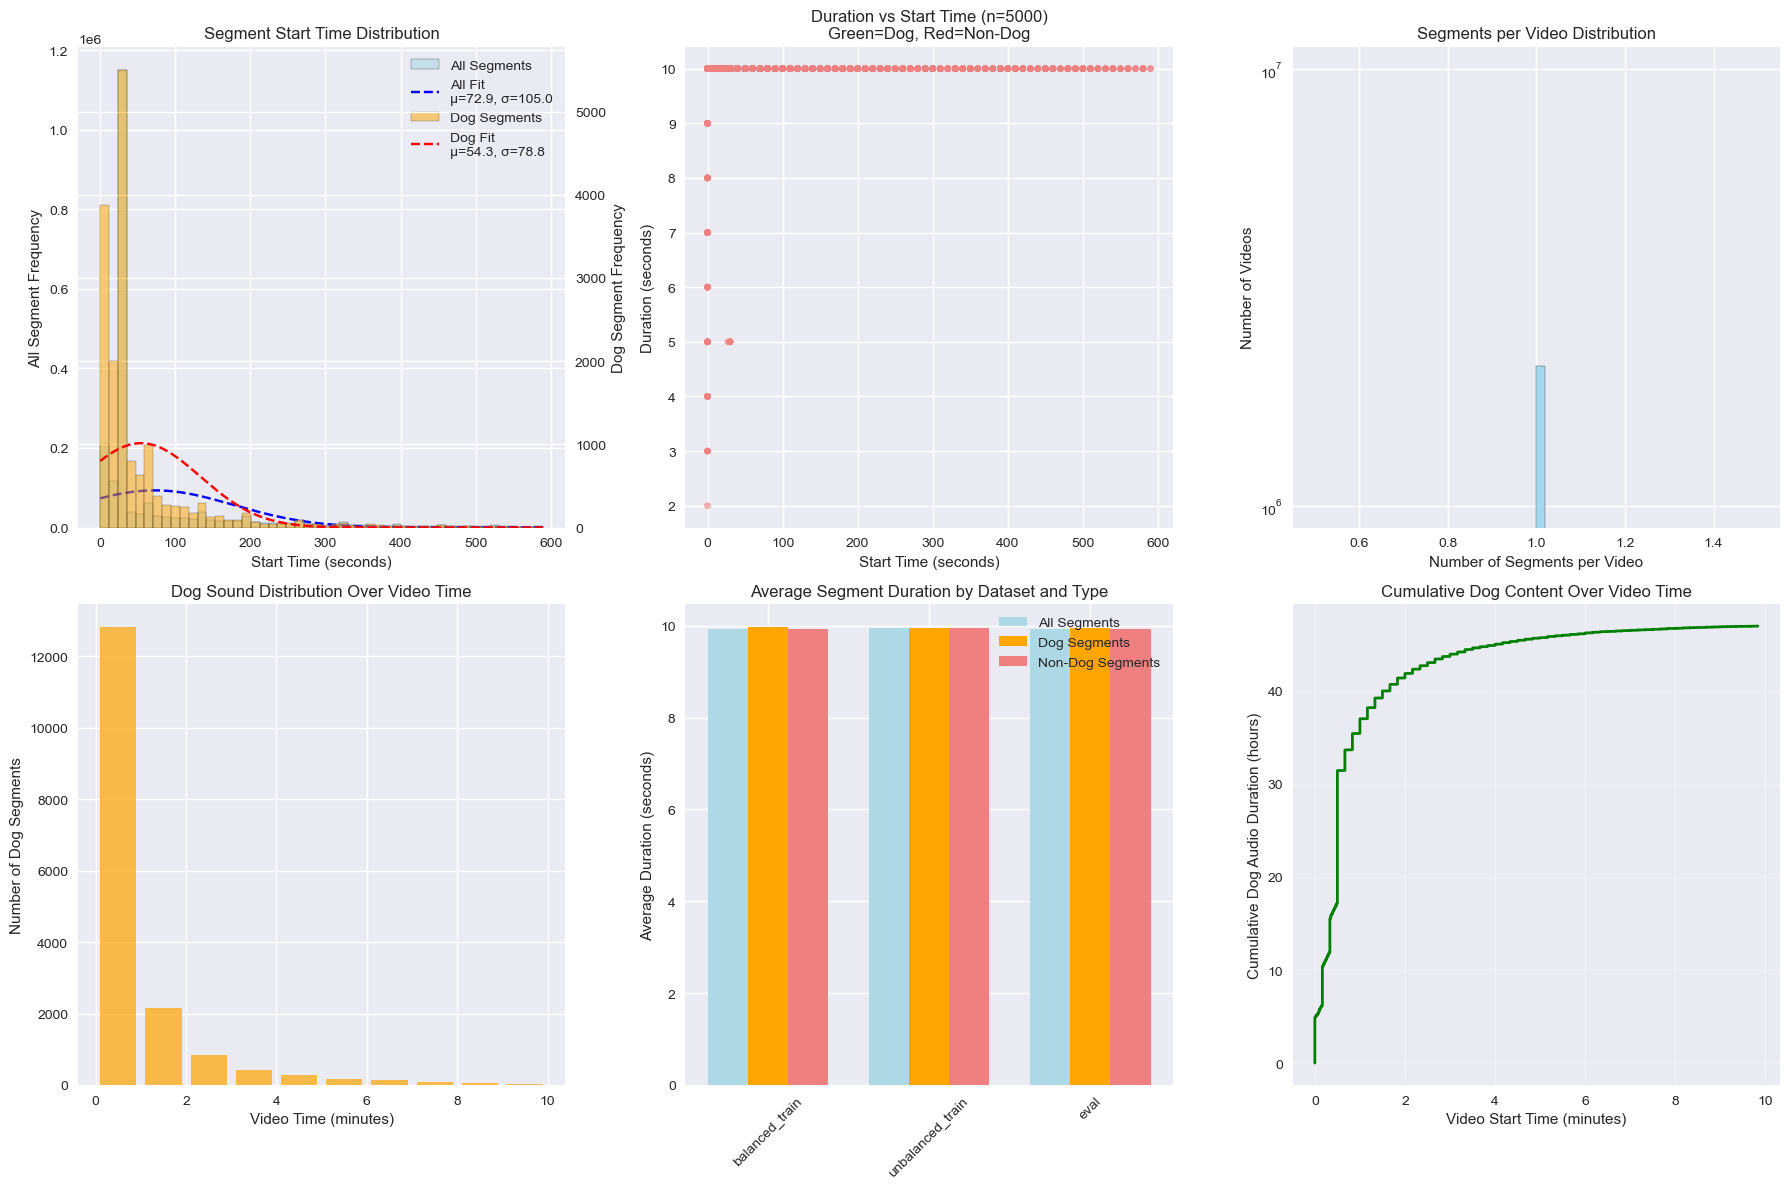


Temporal Statistics (Enhanced for Dog Content):
---------------------------------------------
Start time range (all): 0.0 - 590.0 seconds
Start time range (dog): 0.0 - 590.0 seconds
Average dog segment start time: 54.3 seconds
Most common dog start time: 30.0 seconds

Duration Patterns:
Most common duration (all): 10.0 seconds
Most common duration (dog): 10.0 seconds

Video-level Dog Content Analysis:
Videos with dog content: 16,969
Average earliest dog sound: 54.3 seconds into video
Average latest dog sound: 54.3 seconds into video
Average dog segments per video: 1.0
Videos with dog sounds in first 30 seconds: 6,248
Videos with first dog sound after 5 minutes: 448

Timing by dataset:
  balanced_train:
    Avg start time: 105.2s
    Avg dog start time: 60.5s
    Avg duration: 9.9s
    Total duration: 61.2 hours
  unbalanced_train:
    Avg start time: 72.3s
    Avg dog start time: 54.3s
    Avg duration: 10.0s
    Total duration: 5647.9 hours
  eval:
    Avg start time: 95.1s
    Avg d

In [8]:
# Temporal analysis of audio segments with focus on dog sounds
print("Temporal Analysis (Enhanced for Dog Sounds)")
print("=" * 45)

# Analyze segment timing within videos
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Start time distribution (all vs dog segments, enhanced)
all_start_times = combined_df['start_seconds']
dog_start_times = combined_df[combined_df['has_dog_sounds']]['start_seconds']

# Primary axis for all segments
ax_all = axes[0, 0]
n_all, bins_all, _ = ax_all.hist(all_start_times, bins=50, alpha=0.6, 
                                 label='All Segments', color='lightblue', edgecolor='black')

# Fit Gaussian to all segments
mu_all, std_all = norm.fit(all_start_times)
x_all = np.linspace(bins_all[0], bins_all[-1], 500)
pdf_all = norm.pdf(x_all, mu_all, std_all) * len(all_start_times) * (bins_all[1] - bins_all[0])
ax_all.plot(x_all, pdf_all, 'b--', label=f'All Fit\nμ={mu_all:.1f}, σ={std_all:.1f}')
ax_all.set_xlabel('Start Time (seconds)')
ax_all.set_ylabel('All Segment Frequency')
ax_all.set_title('Segment Start Time Distribution')

# Secondary axis for dog segments
ax_dog = ax_all.twinx()
if len(dog_start_times) > 0:
    n_dog, bins_dog, _ = ax_dog.hist(dog_start_times, bins=50, alpha=0.5, 
                                     label='Dog Segments', color='orange', edgecolor='black')

    # Fit Gaussian to dog segments
    mu_dog, std_dog = norm.fit(dog_start_times)
    x_dog = np.linspace(bins_dog[0], bins_dog[-1], 500)
    pdf_dog = norm.pdf(x_dog, mu_dog, std_dog) * len(dog_start_times) * (bins_dog[1] - bins_dog[0])
    ax_dog.plot(x_dog, pdf_dog, 'r--', label=f'Dog Fit\nμ={mu_dog:.1f}, σ={std_dog:.1f}')
    ax_dog.set_ylabel('Dog Segment Frequency')

# Combine legends
lines_all, labels_all = ax_all.get_legend_handles_labels()
lines_dog, labels_dog = ax_dog.get_legend_handles_labels()
ax_all.legend(lines_all + lines_dog, labels_all + labels_dog, loc='upper right')

# 2. Duration vs Start time scatter plot (colored by dog content)
sample_size = min(5000, len(combined_df))
sample_df = combined_df.sample(n=sample_size, random_state=42)

# Create color mapping
colors = ['lightcoral' if not has_dog else 'lightgreen' for has_dog in sample_df['has_dog_sounds']]

scatter = axes[0, 1].scatter(sample_df['start_seconds'], sample_df['duration'], 
                           alpha=0.6, s=20, c=colors)
axes[0, 1].set_xlabel('Start Time (seconds)')
axes[0, 1].set_ylabel('Duration (seconds)')
axes[0, 1].set_title(f'Duration vs Start Time (n={sample_size})\nGreen=Dog, Red=Non-Dog')

# 3. Segments per video distribution (with dog content breakdown)
segments_per_video = combined_df['ytid'].value_counts()
axes[0, 2].hist(segments_per_video.values, bins=50, alpha=0.7, edgecolor='black', color='skyblue')
axes[0, 2].set_xlabel('Number of Segments per Video')
axes[0, 2].set_ylabel('Number of Videos')
axes[0, 2].set_title('Segments per Video Distribution')
axes[0, 2].set_yscale('log')

# 4. Dog sound timing patterns
if len(dog_start_times) > 0:
    # Analyze dog sounds by time bins
    time_bins = range(0, int(dog_start_times.max()) + 60, 60)  # 1-minute bins
    dog_time_hist, bin_edges = np.histogram(dog_start_times, bins=time_bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    axes[1, 0].bar(bin_centers/60, dog_time_hist, width=0.8, alpha=0.7, color='orange')
    axes[1, 0].set_xlabel('Video Time (minutes)')
    axes[1, 0].set_ylabel('Number of Dog Segments')
    axes[1, 0].set_title('Dog Sound Distribution Over Video Time')

# 5. Average segment duration by dataset and content type
duration_analysis = []
for dataset in combined_df['dataset'].unique():
    dataset_df = combined_df[combined_df['dataset'] == dataset]
    
    all_avg = dataset_df['duration'].mean()
    dog_avg = dataset_df[dataset_df['has_dog_sounds']]['duration'].mean()
    non_dog_avg = dataset_df[~dataset_df['has_dog_sounds']]['duration'].mean()
    
    duration_analysis.append({
        'dataset': dataset,
        'all_segments': all_avg,
        'dog_segments': dog_avg if not np.isnan(dog_avg) else 0,
        'non_dog_segments': non_dog_avg if not np.isnan(non_dog_avg) else 0
    })

datasets = [d['dataset'] for d in duration_analysis]
x_pos = np.arange(len(datasets))
width = 0.25

dog_durations = [d['dog_segments'] for d in duration_analysis]
non_dog_durations = [d['non_dog_segments'] for d in duration_analysis]
all_durations = [d['all_segments'] for d in duration_analysis]

axes[1, 1].bar(x_pos - width, all_durations, width, label='All Segments', color='lightblue')
axes[1, 1].bar(x_pos, dog_durations, width, label='Dog Segments', color='orange')
axes[1, 1].bar(x_pos + width, non_dog_durations, width, label='Non-Dog Segments', color='lightcoral')

axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels(datasets, rotation=45)
axes[1, 1].set_ylabel('Average Duration (seconds)')
axes[1, 1].set_title('Average Segment Duration by Dataset and Type')
axes[1, 1].legend()

# 6. Cumulative dog content over video time
if len(dog_segments) > 0:
    # Create cumulative plot showing how dog content accumulates over video time
    dog_sorted_by_time = dog_segments.sort_values('start_seconds')
    cumulative_duration = dog_sorted_by_time['duration'].cumsum()
    
    axes[1, 2].plot(dog_sorted_by_time['start_seconds']/60, cumulative_duration/3600, 
                    color='green', linewidth=2)
    axes[1, 2].set_xlabel('Video Start Time (minutes)')
    axes[1, 2].set_ylabel('Cumulative Dog Audio Duration (hours)')
    axes[1, 2].set_title('Cumulative Dog Content Over Video Time')
    axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Temporal statistics
print("\nTemporal Statistics (Enhanced for Dog Content):")
print("-" * 45)
print(f"Start time range (all): {combined_df['start_seconds'].min():.1f} - {combined_df['start_seconds'].max():.1f} seconds")

if len(dog_start_times) > 0:
    print(f"Start time range (dog): {dog_start_times.min():.1f} - {dog_start_times.max():.1f} seconds")
    print(f"Average dog segment start time: {dog_start_times.mean():.1f} seconds")
    print(f"Most common dog start time: {dog_start_times.mode().iloc[0]:.1f} seconds" if len(dog_start_times.mode()) > 0 else "No clear mode")

print(f"\nDuration Patterns:")
print(f"Most common duration (all): {combined_df['duration'].mode().iloc[0]:.1f} seconds")
if len(dog_segments) > 0:
    print(f"Most common duration (dog): {dog_segments['duration'].mode().iloc[0]:.1f} seconds" if len(dog_segments['duration'].mode()) > 0 else "No clear mode")

# Video-level dog content timing analysis
print(f"\nVideo-level Dog Content Analysis:")
video_dog_stats = combined_df[combined_df['has_dog_sounds']].groupby('ytid').agg({
    'start_seconds': ['min', 'max', 'mean'],
    'duration': 'sum',
    'has_dog_sounds': 'count'
}).round(2)

video_dog_stats.columns = ['earliest_dog_start', 'latest_dog_start', 'avg_dog_start', 'total_dog_duration', 'num_dog_segments']

if len(video_dog_stats) > 0:
    print(f"Videos with dog content: {len(video_dog_stats):,}")
    print(f"Average earliest dog sound: {video_dog_stats['earliest_dog_start'].mean():.1f} seconds into video")
    print(f"Average latest dog sound: {video_dog_stats['latest_dog_start'].mean():.1f} seconds into video")
    print(f"Average dog segments per video: {video_dog_stats['num_dog_segments'].mean():.1f}")
    
    # Find videos with early vs late dog content
    early_dog_videos = len(video_dog_stats[video_dog_stats['earliest_dog_start'] < 30])
    late_dog_videos = len(video_dog_stats[video_dog_stats['earliest_dog_start'] > 300])
    
    print(f"Videos with dog sounds in first 30 seconds: {early_dog_videos:,}")
    print(f"Videos with first dog sound after 5 minutes: {late_dog_videos:,}")

print(f"\nTiming by dataset:")
for dataset in combined_df['dataset'].unique():
    subset = combined_df[combined_df['dataset'] == dataset]
    dog_subset = subset[subset['has_dog_sounds']]
    print(f"  {dataset}:")
    print(f"    Avg start time: {subset['start_seconds'].mean():.1f}s")
    print(f"    Avg dog start time: {dog_subset['start_seconds'].mean():.1f}s" if len(dog_subset) > 0 else "    No dog segments")
    print(f"    Avg duration: {subset['duration'].mean():.1f}s")
    print(f"    Total duration: {subset['duration'].sum()/3600:.1f} hours")


## Kaggle Dog Inertia and Behavior Analysis Dataset

Let's now examine the Kaggle datasets for dog behavior and inertial data.

### Sources

https://www.kaggle.com/datasets/arashnic/animal-behavior-analysis

https://www.kaggle.com/datasets/benjamingray44/inertial-data-for-dog-behaviour-classification

## Data Preprocessing


In [9]:
# Updated Kaggle Dog Behavior Dataset Analysis
print("## Kaggle Dog Behavior Analysis Dataset (#1)")
print("=" * 55)
print("Dataset: Accelerometer & Gyroscope Dog Activity Recognition")
print("Sensors: ActiGraph GT9X Link (100 Hz sampling rate)")
print("Locations: Back harness + Neck collar")
print("Activities: 7 dog behaviors")
print("  Static Tasks: Sit, Stand, Lie down")
print("  Dynamic Tasks: Walk, Trot, Play, Treat search")

# Clear previous datasets and reload with updated paths
kaggle1_datasets = {}

# Load Kaggle1 Behavior Analysis Data
try:
    # Load DogInfo
    dog_info_path = kaggle_behavior_path / "DogInfo.xlsx"
    if dog_info_path.exists():
        dog_info = pd.read_excel(dog_info_path)
        kaggle1_datasets['dog_info'] = dog_info
        print(f"\n✓ Loaded DogInfo: {len(dog_info)} dogs")
    else:
        print(f"❌ DogInfo.xlsx not found at {dog_info_path}")
    
    # Load DogMoveData (direct CSV file)
    move_data_path = kaggle_behavior_path / "DogMoveData.csv" 
    if move_data_path.exists():
        print(f"Loading DogMoveData...")
        move_data = pd.read_csv(move_data_path)
        kaggle1_datasets['move_data'] = move_data
        print(f"✓ Loaded DogMoveData: {len(move_data):,} records")
        print(f"  File size: {move_data_path.stat().st_size / (1024**3):.2f} GB")
    else:
        print(f"❌ DogMoveData.csv not found at {move_data_path}")
    
except Exception as e:
    print(f"❌ Error loading behavior data: {e}")

# Define task categories based on the dataset description
static_tasks = ['Task sit', 'Task stand', 'Task lie down']
dynamic_tasks = ['Task walk', 'Task trot', 'Task play', 'Task treat search']

# Display basic information
if kaggle1_datasets:
    print(f"\nDataset Overview:")
    print("-" * 25)
    
    for dataset_name, df in kaggle1_datasets.items():
        print(f"\n📊 {dataset_name.upper()}:")
        print(f"  Shape: {df.shape}")
        print(f"  Columns: {list(df.columns)}")
        print(f"  Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
        
        # Additional analysis for movement data
        if dataset_name == 'move_data' and len(df) > 0:
            print(f"\n📈 Movement Data Analysis:")
            unique_dogs = df['DogID'].nunique() if 'DogID' in df.columns else 0
            print(f"  Unique dogs: {unique_dogs}")
            
            if 'Task' in df.columns:
                unique_tasks = df['Task'].nunique()
                print(f"  Unique tasks: {unique_tasks}")
                
                # Task distribution
                task_counts = df['Task'].value_counts()
                print(f"  Task distribution:")
                for task, count in task_counts.items():
                    if task != '<undefined>':
                        task_type = "Static" if task in static_tasks else "Dynamic" if task in dynamic_tasks else "Other"
                        percentage = (count / len(df)) * 100
                        print(f"    {task}: {count:,} records ({percentage:.1f}%) - {task_type}")
            
            if 't_sec' in df.columns:
                total_duration = df['t_sec'].max()
                print(f"  Total recording duration: {total_duration:.1f} seconds ({total_duration/3600:.1f} hours)")
            
            # Sensor data overview
            accel_cols = [col for col in df.columns if col.startswith('A')]
            gyro_cols = [col for col in df.columns if col.startswith('G')]
            print(f"  Accelerometer channels: {len(accel_cols)} ({accel_cols})")
            print(f"  Gyroscope channels: {len(gyro_cols)} ({gyro_cols})")
        
        # Sample data
        print(f"  Sample data:")
        print(df.head(2).to_string(index=False))
        print()
else:
    print("❌ No Kaggle1 datasets loaded successfully")


## Kaggle Dog Behavior Analysis Dataset (#1)
Dataset: Accelerometer & Gyroscope Dog Activity Recognition
Sensors: ActiGraph GT9X Link (100 Hz sampling rate)
Locations: Back harness + Neck collar
Activities: 7 dog behaviors
  Static Tasks: Sit, Stand, Lie down
  Dynamic Tasks: Walk, Trot, Play, Treat search

✓ Loaded DogInfo: 45 dogs
Loading DogMoveData...
✓ Loaded DogMoveData: 10,611,068 records
  File size: 1.85 GB

Dataset Overview:
-------------------------

📊 DOG_INFO:
  Shape: (45, 6)
  Columns: ['DogID', 'Breed', 'Weight', 'Age months', 'Gender', 'NeuteringStatus']
  Memory usage: 0.00 MB
  Sample data:
 DogID            Breed  Weight  Age months  Gender  NeuteringStatus
    16       Crossbreed      13          20       1                0
    18 Belgian Shepherd      29          76       2                0


📊 MOVE_DATA:
  Shape: (10611068, 20)
  Columns: ['DogID', 'TestNum', 't_sec', 'ABack_x', 'ABack_y', 'ABack_z', 'ANeck_x', 'ANeck_y', 'ANeck_z', 'GBack_x', 'GBack_y', 'GBack_z

### Task Type Distributions

Static vs Dynamic Task Analysis by Breed and Age


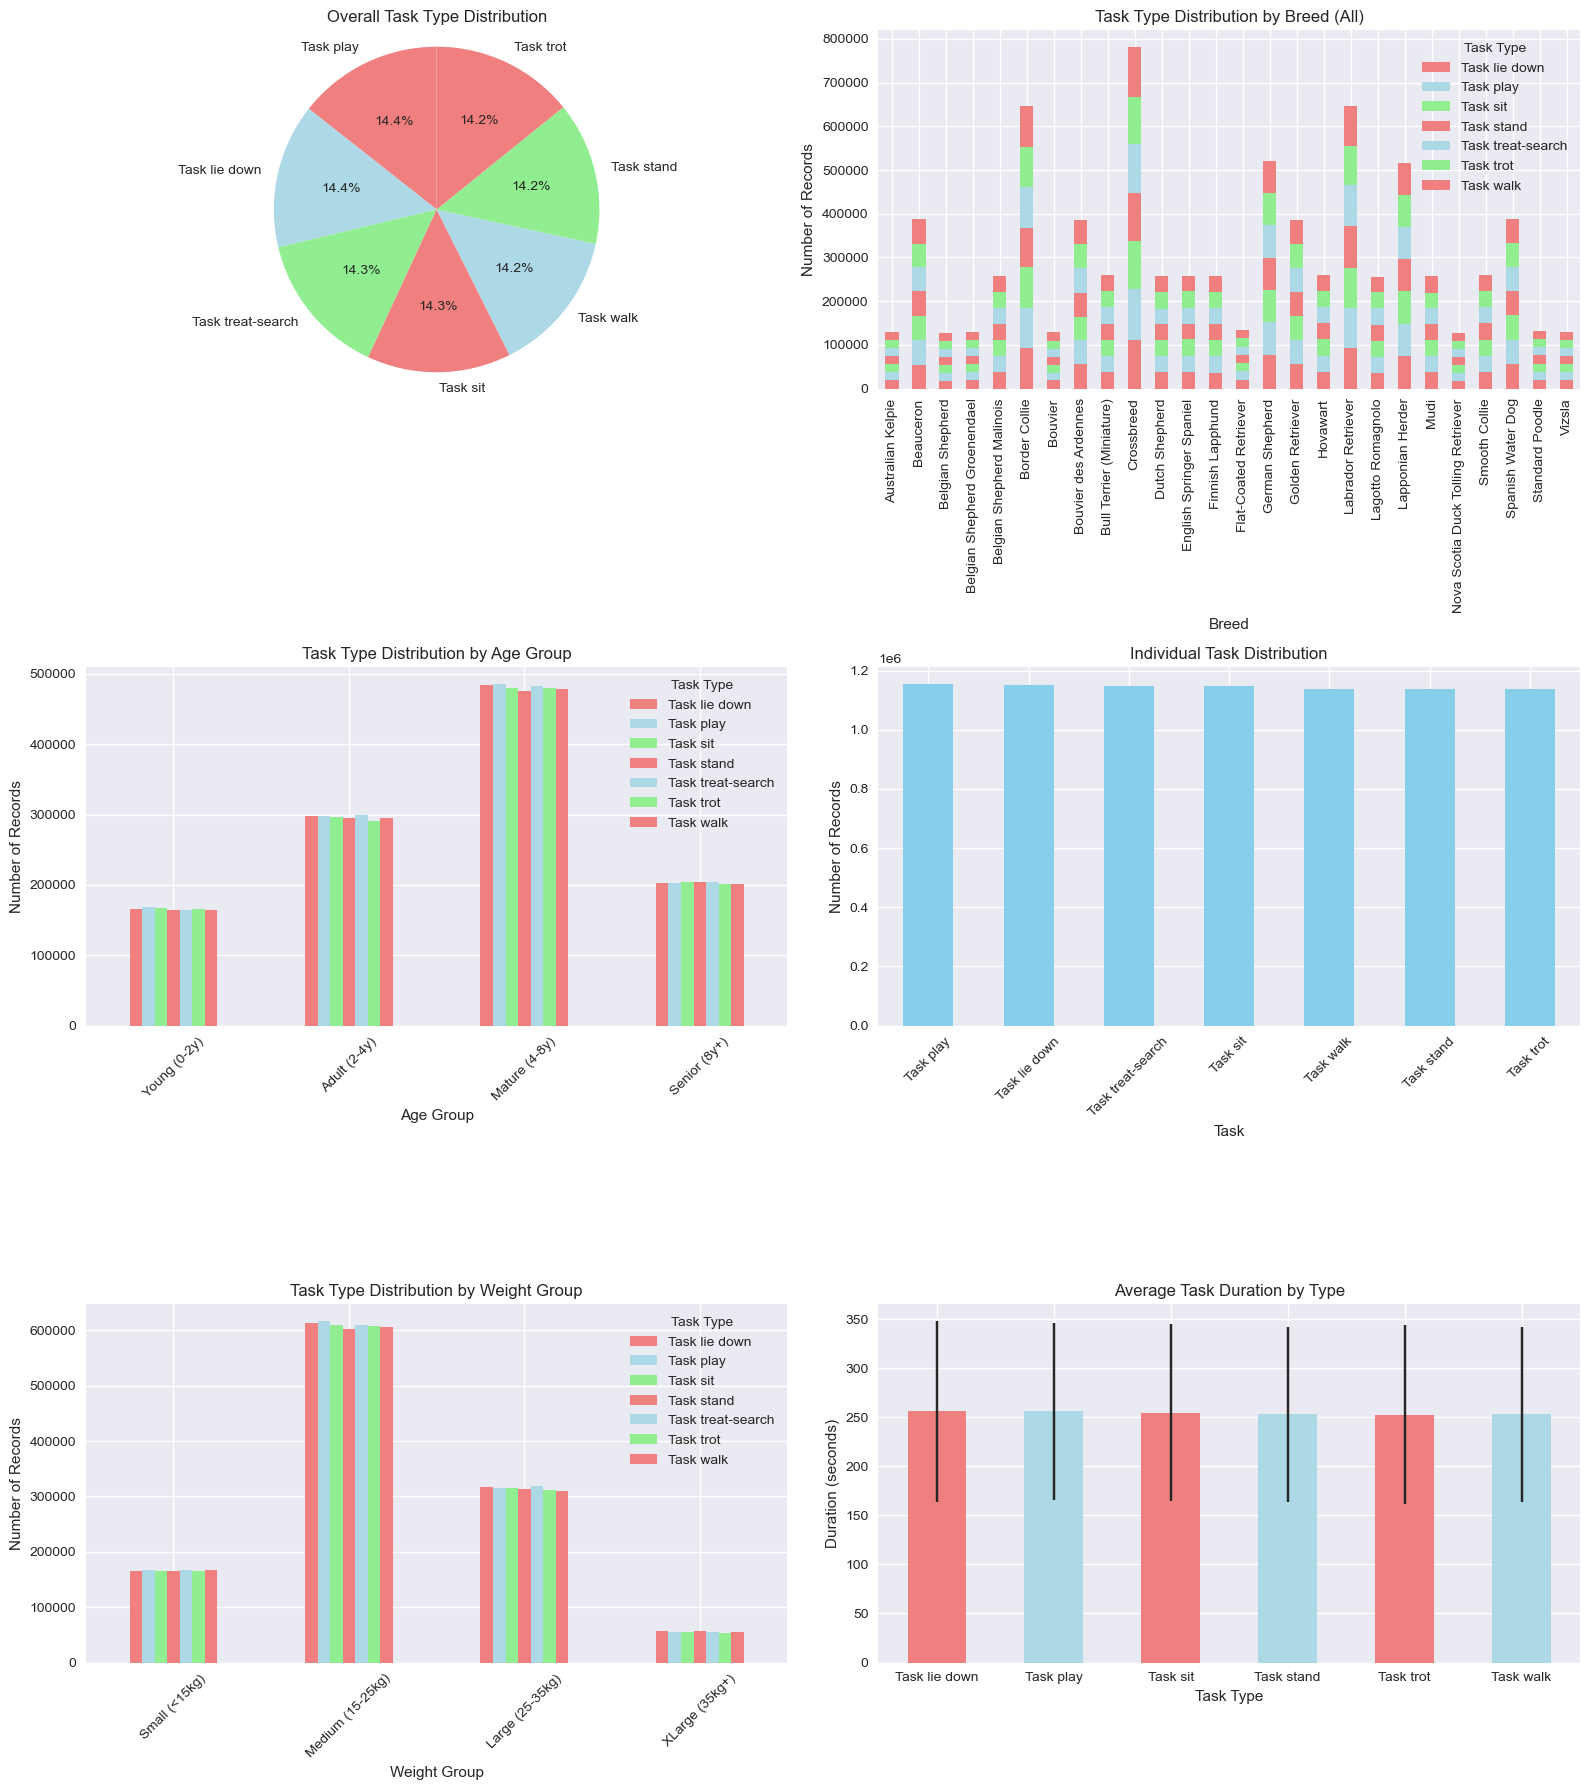


📊 Detailed Analysis Results:
-----------------------------------
Total valid task records: 8,018,317
Dogs with valid task data: 45

Task Type Distribution:
  Task play: 1,153,586 records (14.4%)
  Task lie down: 1,151,662 records (14.4%)
  Task treat-search: 1,149,893 records (14.3%)
  Task sit: 1,146,981 records (14.3%)
  Task walk: 1,139,540 records (14.2%)
  Task stand: 1,138,784 records (14.2%)
  Task trot: 1,137,871 records (14.2%)

Breed Analysis (Task Preferences):
  Australian Kelpie: 43.2% Static, 42.4% Dynamic
  Beauceron: 42.8% Static, 43.0% Dynamic
  Belgian Shepherd: 42.8% Static, 42.7% Dynamic
  Belgian Shepherd Groenendael: 44.0% Static, 42.1% Dynamic
  Belgian Shepherd Malinois: 42.8% Static, 43.2% Dynamic

Age Group Analysis:
  Young (0-2y): 42.8% Static, 43.0% Dynamic
  Adult (2-4y): 43.0% Static, 42.6% Dynamic
  Mature (4-8y): 42.8% Static, 42.9% Dynamic
  Senior (8y+): 43.0% Static, 42.7% Dynamic


In [10]:
# Detailed Analysis: Static vs Dynamic Tasks by Breed and Age
if 'dog_info' in kaggle1_datasets and 'move_data' in kaggle1_datasets:
    dog_info = kaggle1_datasets['dog_info']
    move_data = kaggle1_datasets['move_data']
    
    print("Static vs Dynamic Task Analysis by Breed and Age")
    print("=" * 60)
    
    # Merge dog info with movement data
    if 'DogID' in dog_info.columns and 'DogID' in move_data.columns:
        # Create age groups for analysis
        if 'Age months' in dog_info.columns:
            dog_info['Age_Group'] = pd.cut(dog_info['Age months'], 
                                         bins=[0, 24, 48, 96, float('inf')], 
                                         labels=['Young (0-2y)', 'Adult (2-4y)', 'Mature (4-8y)', 'Senior (8y+)'])
        
        # Filter out undefined tasks
        valid_tasks = move_data[move_data['Task'] != '<undefined>'].copy()
        
        if len(valid_tasks) > 0:
            # Add task type classification
            valid_tasks['Task_Category'] = valid_tasks['Task'].apply(
                lambda x: 'Static' if x in static_tasks else 'Dynamic' if x in dynamic_tasks else 'Other'
            )
            
            # Merge with dog info
            analysis_df = valid_tasks.merge(dog_info, on='DogID', how='left')
            analysis_df.to_csv("static_dynamic_task_analysis.csv", index=False)
            
            # Create comprehensive analysis plots
            fig, axes = plt.subplots(3, 2, figsize=(16, 18))
            
            # 1. Overall Static vs Dynamic distribution
            task_type_counts = analysis_df['Task'].value_counts()
            colors = ['lightcoral', 'lightblue', 'lightgreen']
            axes[0, 0].pie(task_type_counts.values, labels=task_type_counts.index, 
                        autopct='%1.1f%%', startangle=90, colors=colors)
            axes[0, 0].set_title('Overall Task Type Distribution')
            axes[0, 0].axis('equal')  # Fix: ensures pie chart is circular
            
            # 2. Task distribution by breed (top 8 breeds)
            # if 'Breed' in analysis_df.columns:
            #     breed_task_counts = analysis_df.groupby(['Breed', 'Task_Type']).size().unstack(fill_value=0)
            #     top_breeds = analysis_df['Breed'].value_counts().head(8).index
            #     breed_subset = breed_task_counts.loc[top_breeds]
                
            #     breed_subset.plot(kind='bar', stacked=True, ax=axes[0, 1], 
            #                     color=['lightcoral', 'lightblue', 'lightgreen'])
            #     axes[0, 1].set_title('Task Type Distribution by Breed (Top 8)')
            #     axes[0, 1].set_xlabel('Breed')
            #     axes[0, 1].set_ylabel('Number of Records')
            #     axes[0, 1].tick_params(axis='x', rotation=45)
            #     axes[0, 1].legend(title='Task Type')
            
            # 2. Task distribution by breed (all breeds)
            if 'Breed' in analysis_df.columns:
                breed_task_counts = analysis_df.groupby(['Breed', 'Task']).size().unstack(fill_value=0)
                breed_task_counts.plot(kind='bar', stacked=True, ax=axes[0, 1], 
                                    color=['lightcoral', 'lightblue', 'lightgreen'])
                axes[0, 1].set_title('Task Type Distribution by Breed (All)')
                axes[0, 1].set_xlabel('Breed')
                axes[0, 1].set_ylabel('Number of Records')
                axes[0, 1].tick_params(axis='x', rotation=90)  # More readable with many breeds
                axes[0, 1].legend(title='Task Type')
            
            # 3. Task distribution by age group
            if 'Age_Group' in analysis_df.columns:
                age_task_counts = analysis_df.groupby(['Age_Group', 'Task']).size().unstack(fill_value=0)
                age_task_counts.plot(kind='bar', ax=axes[1, 0], 
                                   color=['lightcoral', 'lightblue', 'lightgreen'])
                axes[1, 0].set_title('Task Type Distribution by Age Group')
                axes[1, 0].set_xlabel('Age Group')
                axes[1, 0].set_ylabel('Number of Records')
                axes[1, 0].tick_params(axis='x', rotation=45)
                axes[1, 0].legend(title='Task Type')
            
            # 4. Specific task breakdown
            task_counts = analysis_df['Task'].value_counts()
            task_counts.plot(kind='bar', ax=axes[1, 1], color='skyblue')
            axes[1, 1].set_title('Individual Task Distribution')
            axes[1, 1].set_xlabel('Task')
            axes[1, 1].set_ylabel('Number of Records')
            axes[1, 1].tick_params(axis='x', rotation=45)
            
            # 5. Static vs Dynamic by weight groups
            if 'Weight' in analysis_df.columns:
                analysis_df['Weight_Group'] = pd.cut(analysis_df['Weight'], 
                                                   bins=[0, 15, 25, 35, float('inf')], 
                                                   labels=['Small (<15kg)', 'Medium (15-25kg)', 
                                                          'Large (25-35kg)', 'XLarge (35kg+)'])
                
                weight_task_counts = analysis_df.groupby(['Weight_Group', 'Task']).size().unstack(fill_value=0)
                weight_task_counts.plot(kind='bar', ax=axes[2, 0], 
                                      color=['lightcoral', 'lightblue', 'lightgreen'])
                axes[2, 0].set_title('Task Type Distribution by Weight Group')
                axes[2, 0].set_xlabel('Weight Group')
                axes[2, 0].set_ylabel('Number of Records')
                axes[2, 0].tick_params(axis='x', rotation=45)
                axes[2, 0].legend(title='Task Type')
            
            # 6. Duration analysis by task type
            if 't_sec' in analysis_df.columns:
                # Calculate task durations (assuming consecutive records of same task are continuous)
                task_durations = []
                for dog_id in analysis_df['DogID'].unique():
                    dog_data = analysis_df[analysis_df['DogID'] == dog_id].sort_values('t_sec')
                    # for task_type in ['Static', 'Dynamic']:
                    for task_type in ['Task sit', 'Task stand', 'Task lie down', 'Task walk', 'Task trot', 'Task play', 'Task treat search']:
                        
                        task_data = dog_data[dog_data['Task'] == task_type]
                        if len(task_data) > 0:
                            # Estimate duration based on number of records (100Hz sampling)
                            duration = len(task_data) / 100  # seconds
                            task_durations.append({'Task_Type': task_type, 'Duration': duration})
                
                if task_durations:
                    duration_df = pd.DataFrame(task_durations)
                    duration_summary = duration_df.groupby('Task_Type')['Duration'].agg(['mean', 'std']).fillna(0)
                    
                    duration_summary['mean'].plot(kind='bar', ax=axes[2, 1], 
                                                yerr=duration_summary['std'], 
                                                capsize=5, color=['lightcoral', 'lightblue'])
                    axes[2, 1].set_title('Average Task Duration by Type')
                    axes[2, 1].set_xlabel('Task Type')
                    axes[2, 1].set_ylabel('Duration (seconds)')
                    axes[2, 1].tick_params(axis='x', rotation=0)
            
            plt.tight_layout()
            plt.show()
            
            # Print detailed statistics
            print("\n📊 Detailed Analysis Results:")
            print("-" * 35)
            
            print(f"Total valid task records: {len(analysis_df):,}")
            print(f"Dogs with valid task data: {analysis_df['DogID'].nunique()}")
            
            # Task type distribution
            print(f"\nTask Type Distribution:")
            for task_type, count in task_type_counts.items():
                percentage = (count / len(analysis_df)) * 100
                print(f"  {task_type}: {count:,} records ({percentage:.1f}%)")
            
            # Breed analysis
            if 'Breed' in analysis_df.columns:
                print(f"\nBreed Analysis (Task Preferences):")
                breed_task_pct = analysis_df.groupby(['Breed', 'Task_Category']).size().unstack(fill_value=0)
                breed_task_pct = breed_task_pct.div(breed_task_pct.sum(axis=1), axis=0) * 100
                
                for breed in breed_task_pct.index[:5]:  # Top 5 breeds
                    static_pct = breed_task_pct.loc[breed, 'Static'] if 'Static' in breed_task_pct.columns else 0
                    dynamic_pct = breed_task_pct.loc[breed, 'Dynamic'] if 'Dynamic' in breed_task_pct.columns else 0
                    print(f"  {breed}: {static_pct:.1f}% Static, {dynamic_pct:.1f}% Dynamic")
            
            # Age group analysis
            if 'Age_Group' in analysis_df.columns:
                print(f"\nAge Group Analysis:")
                age_task_pct = analysis_df.groupby(['Age_Group', 'Task_Category']).size().unstack(fill_value=0)
                age_task_pct = age_task_pct.div(age_task_pct.sum(axis=1), axis=0) * 100
                
                for age_group in age_task_pct.index:
                    static_pct = age_task_pct.loc[age_group, 'Static'] if 'Static' in age_task_pct.columns else 0
                    dynamic_pct = age_task_pct.loc[age_group, 'Dynamic'] if 'Dynamic' in age_task_pct.columns else 0
                    print(f"  {age_group}: {static_pct:.1f}% Static, {dynamic_pct:.1f}% Dynamic")
            
        else:
            print("❌ No valid task data found (all tasks are undefined)")
    else:
        print("❌ Cannot merge datasets: DogID column not found in both datasets")
else:
    print("❌ Required datasets not loaded. Please run the previous cell first.")


### Behavior Distributions

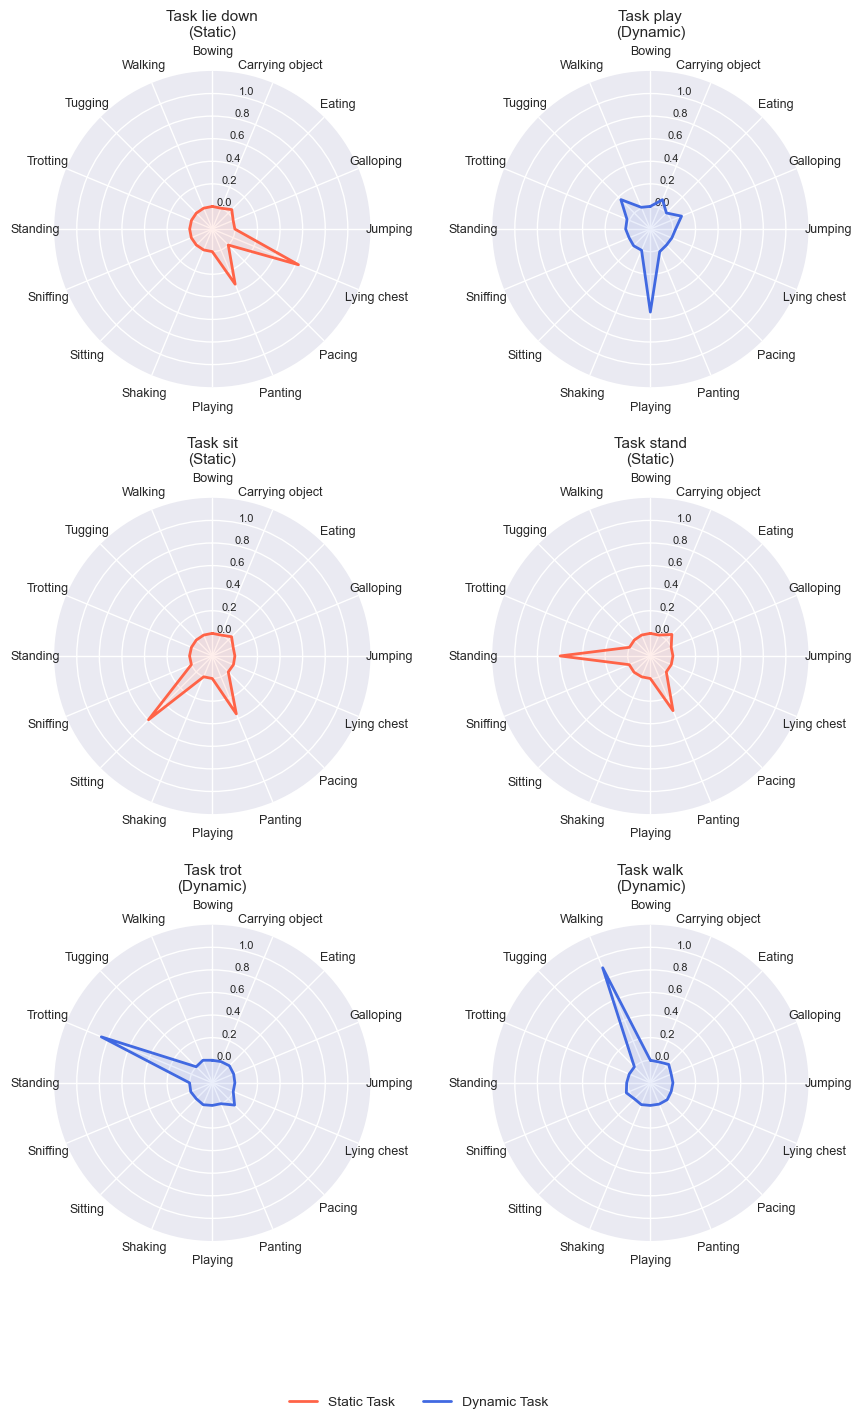

In [11]:
# ---------------- Spider Subplots: One per Task (Extended Radial Range & Custom Ticks) ----------------
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import numpy as np

# Filter to only tasks of interest
defined_tasks = static_tasks + dynamic_tasks
task_behavior_df = analysis_df[analysis_df['Task'].isin(defined_tasks)].copy()

# Gather behavior annotations
behavior_cols = ['Behavior_1', 'Behavior_2', 'Behavior_3']
melted_behaviors = task_behavior_df.melt(id_vars='Task', value_vars=behavior_cols,
                                         value_name='Behavior')

# Keep only valid (non-undefined) behavior annotations
melted_behaviors = melted_behaviors[~melted_behaviors['Behavior'].isin([None, np.nan, '<undefined>'])]

# Count valid behaviors per task
behavior_counts = melted_behaviors.groupby(['Task', 'Behavior']).size().unstack(fill_value=0)
behavior_pct = behavior_counts.div(behavior_counts.sum(axis=1), axis=0)
behavior_pct = behavior_pct.reindex(sorted(behavior_pct.columns), axis=1)

# Setup spider plot
tasks = behavior_pct.index
labels = behavior_pct.columns.tolist()
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

# Task color style
task_colors = {'Static': 'tomato', 'Dynamic': 'royalblue'}

# Grid layout
n_tasks = len(tasks)
n_cols = 2
n_rows = int(np.ceil(n_tasks / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, subplot_kw=dict(polar=True), figsize=(n_cols * 5, n_rows * 5))
axes = axes.flatten() if n_tasks > 1 else [axes]

for i, task in enumerate(tasks):
    values = behavior_pct.loc[task].tolist()
    values += values[:1]
    task_type = 'Static' if task in static_tasks else 'Dynamic'

    ax = axes[i]
    ax.plot(angles, values, color=task_colors.get(task_type, 'gray'), linewidth=2)
    ax.fill(angles, values, alpha=0.1, color=task_colors.get(task_type, 'gray'))

    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_thetagrids(np.degrees(angles[:-1]), labels, fontsize=9)

    # Custom radial settings
    ax.set_ylim(-0.2, 1.2)
    ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels(['0.0', '0.2', '0.4', '0.6', '0.8', '1.0'], fontsize=8)
    ax.set_rlabel_position(180 / num_vars)

    # Adjust title spacing to avoid axis overlap
    ax.set_title(f'{task}\n({task_type})', size=11, pad=25)

# Hide unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Shared legend
legend_elements = [
    Line2D([0], [0], color='tomato', lw=2, label='Static Task'),
    Line2D([0], [0], color='royalblue', lw=2, label='Dynamic Task')
]
fig.legend(handles=legend_elements, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.02), fontsize=10)

plt.subplots_adjust(hspace=0.35, wspace=0.3, bottom=0.1)
plt.show()


### Sensor Data Distributions

Accelerometer & Gyroscope Sensor Analysis

📊 Signal-to-Noise Ratio (SNR) Summary
--------------------------------------------------
Neck Accelerometer SNR: 1.5596
Back Accelerometer SNR: 1.7151
Neck Gyroscope SNR:     0.6088
Back Gyroscope SNR:     0.5906


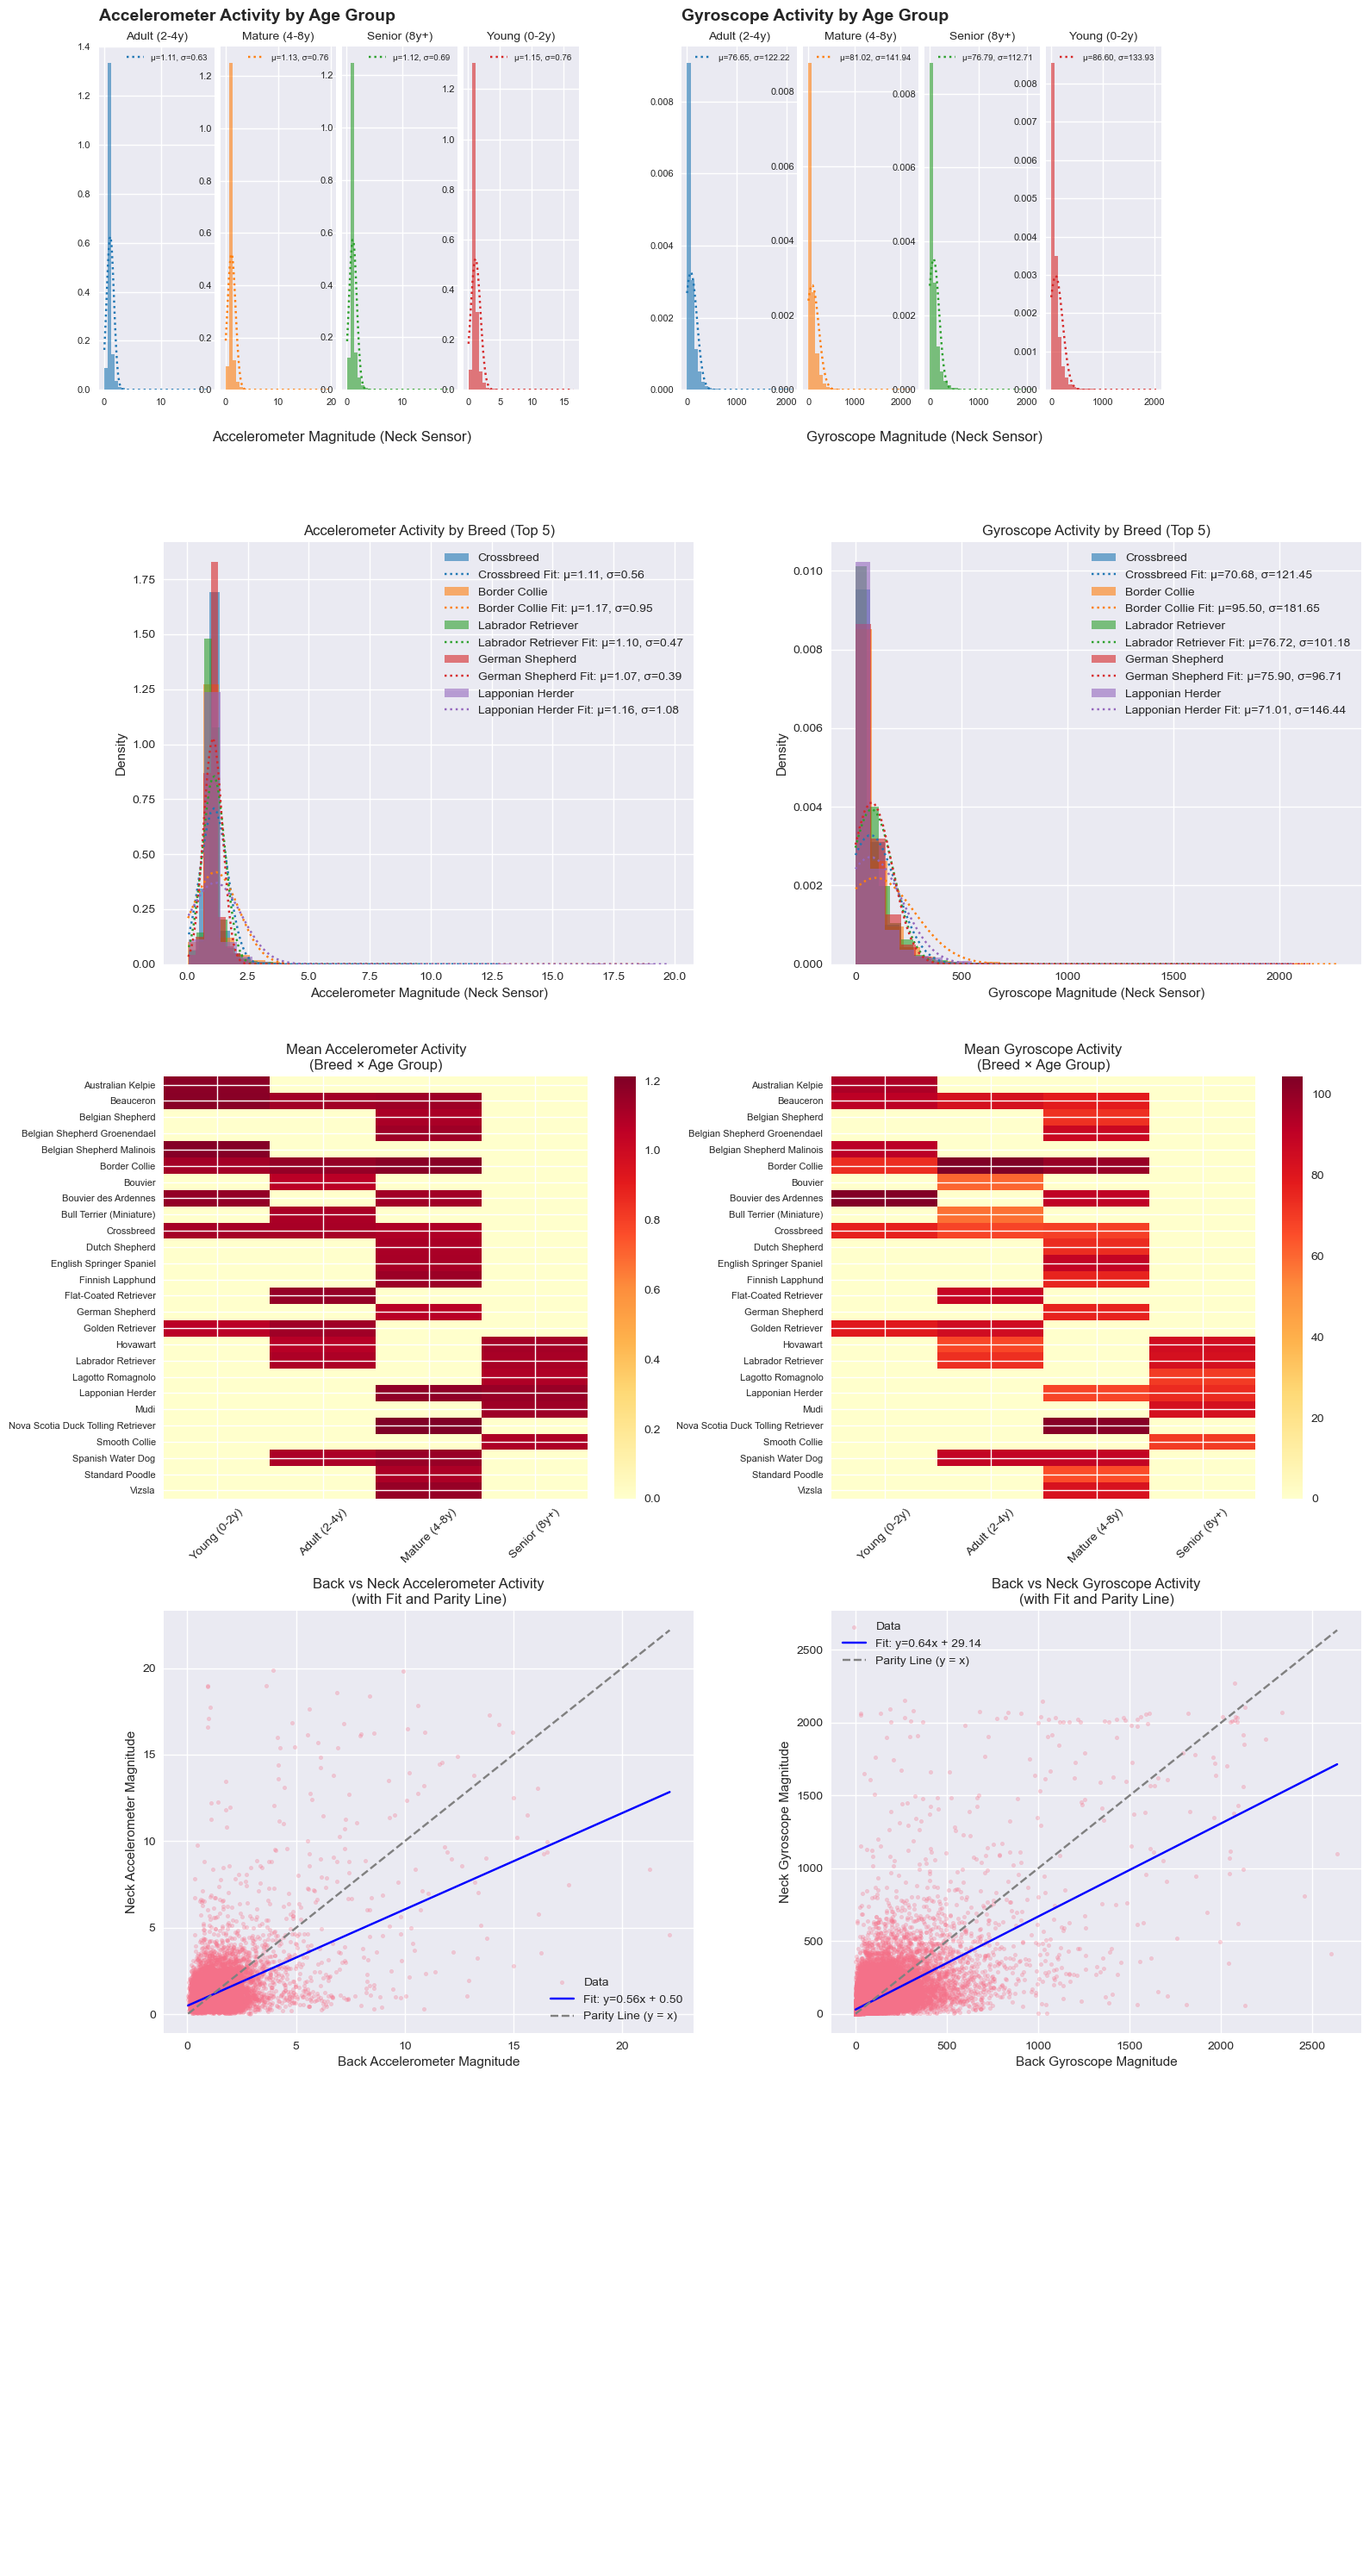


📈 Linear Fit Summary: Back vs Neck Accelerometer
--------------------------------------------------
Fit Equation: y = 0.5565x + 0.4968
Mean Squared Error: 0.3857
Deviation from parity slope (1.0): 0.4435

📈 Linear Fit Summary: Back vs Neck Gyroscope
--------------------------------------------------
Fit Equation: y = 0.6394x + 29.1416
Mean Squared Error: 9852.5640
Deviation from parity slope (1.0): 0.3606


In [36]:
from scipy.stats import norm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

# Sensor Data Analysis: Accelerometer & Gyroscope Patterns by Breed and Age
if 'dog_info' in kaggle1_datasets and 'move_data' in kaggle1_datasets:
    dog_info = kaggle1_datasets['dog_info']
    move_data = kaggle1_datasets['move_data']
    
    print("Accelerometer & Gyroscope Sensor Analysis")
    print("=" * 50)

    # Define sensor columns
    accel_neck_cols = ['ANeck_x', 'ANeck_y', 'ANeck_z'] 
    accel_back_cols = ['ABack_x', 'ABack_y', 'ABack_z']
    gyro_neck_cols = ['GNeck_x', 'GNeck_y', 'GNeck_z']
    gyro_back_cols = ['GBack_x', 'GBack_y', 'GBack_z']

    sensor_cols_present = all(col in move_data.columns for col in accel_neck_cols + accel_back_cols + gyro_neck_cols + gyro_back_cols)

    if sensor_cols_present and len(move_data) > 0:
        sample_size = min(50000, len(move_data))
        move_sample = move_data.sample(n=sample_size, random_state=42)
        sensor_analysis = move_sample.merge(dog_info, on='DogID', how='left')

        # Compute magnitudes
        sensor_analysis['AccelNeck_Mag'] = np.sqrt(sensor_analysis[accel_neck_cols].pow(2).sum(axis=1))
        sensor_analysis['AccelBack_Mag'] = np.sqrt(sensor_analysis[accel_back_cols].pow(2).sum(axis=1))
        sensor_analysis['GyroNeck_Mag'] = np.sqrt(sensor_analysis[gyro_neck_cols].pow(2).sum(axis=1))
        sensor_analysis['GyroBack_Mag'] = np.sqrt(sensor_analysis[gyro_back_cols].pow(2).sum(axis=1))

        # -------------------------
        # Signal-to-Noise Ratio (SNR) Calculation
        # -------------------------
        def compute_snr(signal):
            mu = np.mean(signal)
            sigma = np.std(signal)
            return mu / sigma if sigma != 0 else np.nan

        snr_accel_neck = compute_snr(sensor_analysis['AccelNeck_Mag'])
        snr_accel_back = compute_snr(sensor_analysis['AccelBack_Mag'])
        snr_gyro_neck = compute_snr(sensor_analysis['GyroNeck_Mag'])
        snr_gyro_back = compute_snr(sensor_analysis['GyroBack_Mag'])

        print("\n📊 Signal-to-Noise Ratio (SNR) Summary")
        print("--------------------------------------------------")
        print(f"Neck Accelerometer SNR: {snr_accel_neck:.4f}")
        print(f"Back Accelerometer SNR: {snr_accel_back:.4f}")
        print(f"Neck Gyroscope SNR:     {snr_gyro_neck:.4f}")
        print(f"Back Gyroscope SNR:     {snr_gyro_back:.4f}")

        if 'Age months' in sensor_analysis.columns:
            sensor_analysis['Age_Group'] = pd.cut(sensor_analysis['Age months'], 
                                                  bins=[0, 24, 48, 96, float('inf')], 
                                                  labels=['Young (0-2y)', 'Adult (2-4y)', 'Mature (4-8y)', 'Senior (8y+)'])

        # Create plot grid (5 rows, 2 columns now)
        fig, axes = plt.subplots(5, 2, figsize=(16, 30))

        # -------------------------
        # 1. Histogram by Age Group
        # -------------------------
        for col_idx, (sensor_col, title_prefix) in enumerate(zip(
            ['AccelNeck_Mag', 'GyroNeck_Mag'], 
            ['Accelerometer', 'Gyroscope']
        )):
            axes[0, col_idx].set_visible(False)
            if 'Age_Group' in sensor_analysis.columns:
                age_groups = sorted(sensor_analysis['Age_Group'].dropna().unique())
                n = len(age_groups)
                colors = plt.cm.tab10.colors
                base_pos = axes[0, col_idx].get_position()
                x0, y0, width, height = base_pos.x0 - 0.05, base_pos.y0 + 0.1, base_pos.width, base_pos.height
                subplot_width = width / n

                for i, age_group in enumerate(age_groups):
                    sub_x0 = x0 + i * subplot_width
                    sub_ax = fig.add_axes([sub_x0, y0, subplot_width * 0.95, height])

                    data = sensor_analysis[sensor_analysis['Age_Group'] == age_group][sensor_col]
                    color = colors[i % len(colors)]

                    sub_ax.hist(data, bins=30, alpha=0.6, density=True, color=color)
                    mu, std = norm.fit(data)
                    x = np.linspace(data.min(), data.max(), 100)
                    p = norm.pdf(x, mu, std)
                    sub_ax.plot(x, p, linestyle='dotted', color=color, label=f'μ={mu:.2f}, σ={std:.2f}')

                    sub_ax.set_title(str(age_group), fontsize=10)
                    sub_ax.tick_params(axis='both', labelsize=8)
                    sub_ax.legend(fontsize=7)

                fig.text(x0, y0 + height + 0.01, f'{title_prefix} Activity by Age Group', fontsize=14, fontweight='bold')
                fig.text(x0 + width/2, y0 - 0.02, f'{title_prefix} Magnitude (Neck Sensor)', ha='center', fontsize=12)

        # -------------------------
        # 2. Histogram by Breed (Top 5)
        # -------------------------
        if 'Breed' in sensor_analysis.columns:
            top_breeds = sensor_analysis['Breed'].value_counts().head(5).index
            colors = plt.cm.tab10.colors

            for col_idx, (sensor_col, title_prefix) in enumerate(zip(
                ['AccelNeck_Mag', 'GyroNeck_Mag'], 
                ['Accelerometer', 'Gyroscope']
            )):
                ax = axes[1, col_idx]
                for i, breed in enumerate(top_breeds):
                    breed_data = sensor_analysis[sensor_analysis['Breed'] == breed]
                    data = breed_data[sensor_col]
                    color = colors[i % len(colors)]
                    ax.hist(data, bins=30, alpha=0.6, label=breed, density=True, color=color)

                    mu, std = norm.fit(data)
                    x = np.linspace(data.min(), data.max(), 100)
                    p = norm.pdf(x, mu, std)
                    ax.plot(x, p, linestyle='dotted', color=color, label=f'{breed} Fit: μ={mu:.2f}, σ={std:.2f}')

                ax.set_xlabel(f'{title_prefix} Magnitude (Neck Sensor)')
                ax.set_ylabel('Density')
                ax.set_title(f'{title_prefix} Activity by Breed (Top 5)')
                ax.legend()

        # -------------------------
        # 3. Mean Activity Heatmap (Breed × Age Group)
        # -------------------------
        if 'Breed' in sensor_analysis.columns and 'Age_Group' in sensor_analysis.columns:
            summary_stats = sensor_analysis.groupby(['Breed', 'Age_Group']).agg({
                'AccelNeck_Mag': 'mean',
                'GyroNeck_Mag': 'mean'
            }).reset_index()

            for col_idx, (sensor_col, title_prefix) in enumerate(zip(
                ['AccelNeck_Mag', 'GyroNeck_Mag'], 
                ['Accelerometer', 'Gyroscope']
            )):
                ax = axes[2, col_idx]
                pivot = summary_stats.pivot(index='Breed', columns='Age_Group', values=sensor_col)
                im = ax.imshow(pivot.fillna(0), cmap='YlOrRd', aspect='auto')
                ax.set_xticks(range(len(pivot.columns)))
                ax.set_yticks(range(len(pivot.index)))
                ax.set_xticklabels(pivot.columns, rotation=45)
                ax.set_yticklabels(pivot.index, fontsize=8)
                ax.set_title(f'Mean {title_prefix} Activity\n(Breed × Age Group)')
                plt.colorbar(im, ax=ax)

        # -------------------------
        # 4. Back vs Neck Accelerometer Scatter with Fit and Parity Line
        # -------------------------
        x_acc = sensor_analysis['AccelBack_Mag']
        y_acc = sensor_analysis['AccelNeck_Mag']
        ax = axes[3, 0]
        ax.scatter(x_acc, y_acc, alpha=0.3, s=10, label='Data')

        m_acc, b_acc = np.polyfit(x_acc, y_acc, 1)
        x_fit = np.linspace(x_acc.min(), x_acc.max(), 100)
        y_fit = m_acc * x_fit + b_acc
        ax.plot(x_fit, y_fit, color='blue', linestyle='-', label=f'Fit: y={m_acc:.2f}x + {b_acc:.2f}')
        ax.plot(x_fit, x_fit, color='gray', linestyle='--', label='Parity Line (y = x)')

        ax.set_xlabel('Back Accelerometer Magnitude')
        ax.set_ylabel('Neck Accelerometer Magnitude')
        ax.set_title('Back vs Neck Accelerometer Activity\n(with Fit and Parity Line)')
        ax.legend()

        # -------------------------
        # 5. Back vs Neck Gyroscope Scatter with Fit and Parity Line
        # -------------------------
        x_gyro = sensor_analysis['GyroBack_Mag']
        y_gyro = sensor_analysis['GyroNeck_Mag']
        ax = axes[3, 1]
        ax.scatter(x_gyro, y_gyro, alpha=0.3, s=10, label='Data')

        m_gyro, b_gyro = np.polyfit(x_gyro, y_gyro, 1)
        x_fit = np.linspace(x_gyro.min(), x_gyro.max(), 100)
        y_fit = m_gyro * x_fit + b_gyro
        ax.plot(x_fit, y_fit, color='blue', linestyle='-', label=f'Fit: y={m_gyro:.2f}x + {b_gyro:.2f}')
        ax.plot(x_fit, x_fit, color='gray', linestyle='--', label='Parity Line (y = x)')

        ax.set_xlabel('Back Gyroscope Magnitude')
        ax.set_ylabel('Neck Gyroscope Magnitude')
        ax.set_title('Back vs Neck Gyroscope Activity\n(with Fit and Parity Line)')
        ax.legend()

        # -------------------------
        # 6. Hide unused subplots (bottom row)
        # -------------------------
        axes[4, 0].axis('off')
        axes[4, 1].axis('off')

        plt.tight_layout()
        plt.show()

        # -------------------------
        # Console Output: Regression Summary
        # -------------------------
        y_acc_pred = m_acc * x_acc + b_acc
        y_gyro_pred = m_gyro * x_gyro + b_gyro

        mse_acc = mean_squared_error(y_acc, y_acc_pred)
        mse_gyro = mean_squared_error(y_gyro, y_gyro_pred)

        print("\n📈 Linear Fit Summary: Back vs Neck Accelerometer")
        print("--------------------------------------------------")
        print(f"Fit Equation: y = {m_acc:.4f}x + {b_acc:.4f}")
        print(f"Mean Squared Error: {mse_acc:.4f}")
        print(f"Deviation from parity slope (1.0): {abs(m_acc - 1):.4f}")

        print("\n📈 Linear Fit Summary: Back vs Neck Gyroscope")
        print("--------------------------------------------------")
        print(f"Fit Equation: y = {m_gyro:.4f}x + {b_gyro:.4f}")
        print(f"Mean Squared Error: {mse_gyro:.4f}")
        print(f"Deviation from parity slope (1.0): {abs(m_gyro - 1):.4f}")
    else:
        print("❌ Required sensor columns not found or data is empty.")




📈 1. Age vs Accelerometer Magnitude

📊 Pearson Correlation (Age vs Accelerometer): r = -0.0121, p = 3.7157e-02


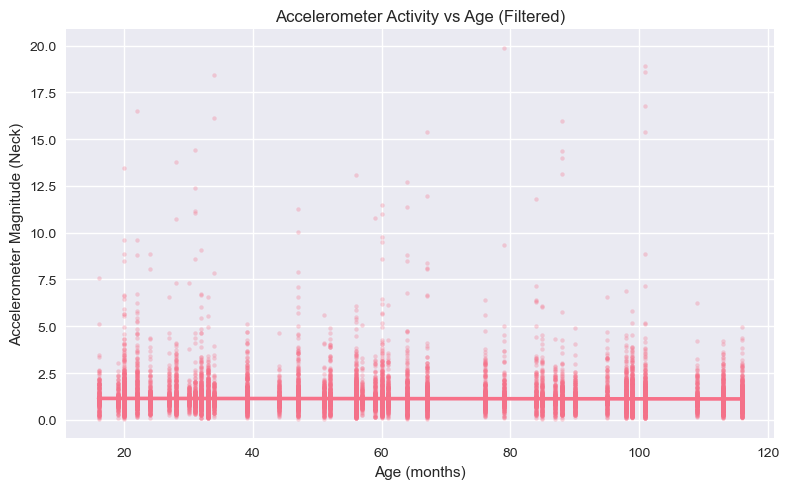

In [13]:
from scipy.stats import pearsonr
import seaborn as sns
import matplotlib.pyplot as plt

# Apply filtering
filtered_df = sensor_analysis[
    (sensor_analysis['Task'] != '<undefined>') &
    (sensor_analysis['Behavior_1']!= '<undefined>')
][['Age months', 'AccelNeck_Mag']].dropna()

# Pearson correlation
r_age, p_age = pearsonr(filtered_df['Age months'], filtered_df['AccelNeck_Mag'])
print(f"📊 Pearson Correlation (Age vs Accelerometer): r = {r_age:.4f}, p = {p_age:.4e}")

# Plot
plt.figure(figsize=(8, 5))
sns.regplot(data=filtered_df, x='Age months', y='AccelNeck_Mag', scatter_kws={'alpha': 0.3, 's': 10})
plt.title('Accelerometer Activity vs Age (Filtered)')
plt.xlabel('Age (months)')
plt.ylabel('Accelerometer Magnitude (Neck)')
plt.tight_layout()
plt.show()


📈 2. Weight vs Accelerometer Magnitude

📊 Pearson Correlation (Weight vs Accelerometer): r = -0.0177, p = 2.2976e-03


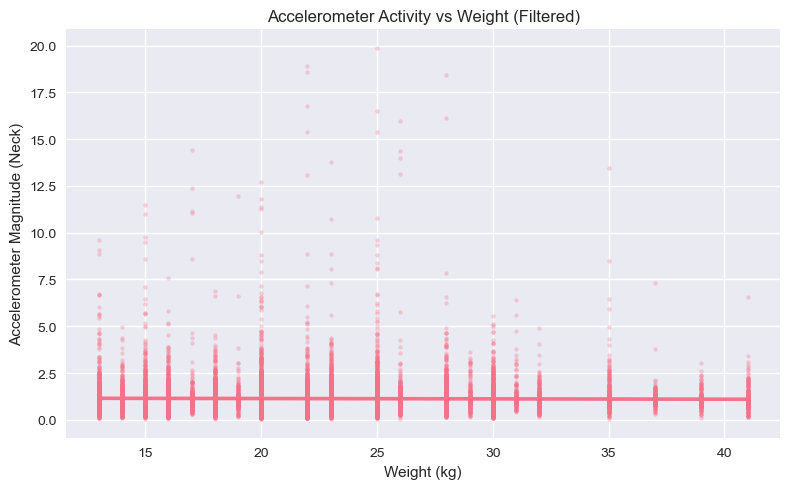

In [14]:
# Apply filtering
filtered_df = sensor_analysis[
    (sensor_analysis['Task'] != '<undefined>') &
    (sensor_analysis['Behavior_1'] != '<undefined>')
][['Weight', 'AccelNeck_Mag']].dropna()

# Pearson correlation
r_weight, p_weight = pearsonr(filtered_df['Weight'], filtered_df['AccelNeck_Mag'])
print(f"📊 Pearson Correlation (Weight vs Accelerometer): r = {r_weight:.4f}, p = {p_weight:.4e}")

# Plot
plt.figure(figsize=(8, 5))
sns.regplot(data=filtered_df, x='Weight', y='AccelNeck_Mag', scatter_kws={'alpha': 0.3, 's': 10})
plt.title('Accelerometer Activity vs Weight (Filtered)')
plt.xlabel('Weight (kg)')
plt.ylabel('Accelerometer Magnitude (Neck)')
plt.tight_layout()
plt.show()


📈 3. Breed vs Accelerometer Magnitude

📊 ANOVA (Breed vs Accelerometer): F = 3.2682, p = 6.3376e-08


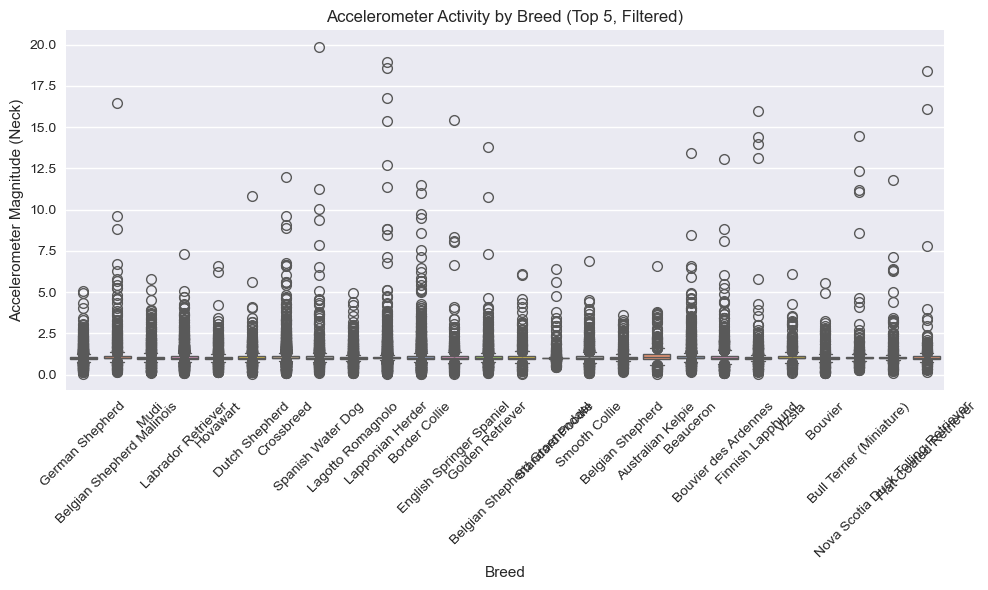

In [17]:
from scipy.stats import f_oneway

# Filter data for valid task and behavior
filtered_df = sensor_analysis[
    (sensor_analysis['Task'] != '<undefined>') &
    (sensor_analysis['Behavior_1'] != '<undefined>') &
    (sensor_analysis['AccelNeck_Mag'].notna())
]

# Select top 5 breeds by count
top_breeds = filtered_df['Breed'].value_counts().head(50).index
breed_subset = filtered_df[filtered_df['Breed'].isin(top_breeds)]

# Prepare groups for ANOVA
breed_groups = [breed_subset[breed_subset['Breed'] == breed]['AccelNeck_Mag'] for breed in top_breeds]

# ANOVA
f_stat, p_val = f_oneway(*breed_groups)
print(f"📊 ANOVA (Breed vs Accelerometer): F = {f_stat:.4f}, p = {p_val:.4e}")

# Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=breed_subset, x='Breed', y='AccelNeck_Mag', palette='Set2')
plt.title('Accelerometer Activity by Breed (Top 5, Filtered)')
plt.xlabel('Breed')
plt.ylabel('Accelerometer Magnitude (Neck)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [18]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Run Tukey HSD
tukey = pairwise_tukeyhsd(endog=breed_subset['AccelNeck_Mag'],
                          groups=breed_subset['Breed'],
                          alpha=0.05)

print(tukey)

                            Multiple Comparison of Means - Tukey HSD, FWER=0.05                             
              group1                             group2               meandiff p-adj   lower   upper  reject
------------------------------------------------------------------------------------------------------------
                 Australian Kelpie                          Beauceron  -0.0302    1.0 -0.1682  0.1077  False
                 Australian Kelpie                   Belgian Shepherd  -0.0936 0.9501 -0.2618  0.0747  False
                 Australian Kelpie       Belgian Shepherd Groenendael  -0.0478    1.0 -0.2111  0.1155  False
                 Australian Kelpie          Belgian Shepherd Malinois   0.0597 0.9996 -0.0913  0.2107  False
                 Australian Kelpie                      Border Collie  -0.0341    1.0 -0.1665  0.0983  False
                 Australian Kelpie                            Bouvier  -0.1284  0.445 -0.2949   0.038  False
                 Au

In [20]:
import pandas as pd

# Convert Tukey HSD results into a DataFrame
tukey_df = pd.DataFrame(data=tukey._results_table.data[1:],  # skip header row
                        columns=tukey._results_table.data[0])  # use header row as column names

# Display the DataFrame
print(tukey_df)

                group1                        group2  meandiff   p-adj  \
0    Australian Kelpie                     Beauceron   -0.0302  1.0000   
1    Australian Kelpie              Belgian Shepherd   -0.0936  0.9501   
2    Australian Kelpie  Belgian Shepherd Groenendael   -0.0478  1.0000   
3    Australian Kelpie     Belgian Shepherd Malinois    0.0597  0.9996   
4    Australian Kelpie                 Border Collie   -0.0341  1.0000   
..                 ...                           ...       ...     ...   
320      Smooth Collie               Standard Poodle    0.0143  1.0000   
321      Smooth Collie                        Vizsla    0.0375  1.0000   
322  Spanish Water Dog               Standard Poodle   -0.0171  1.0000   
323  Spanish Water Dog                        Vizsla    0.0061  1.0000   
324    Standard Poodle                        Vizsla    0.0232  1.0000   

      lower   upper  reject  
0   -0.1682  0.1077   False  
1   -0.2618  0.0747   False  
2   -0.2111  0.1155  

In [22]:
tukey_df[tukey_df['reject'] == True]

,group1,group2,meandiff,p-adj,lower,upper,reject
37,Beauceron,German Shepherd,-0.0930,0.0242,-0.1811,-0.0049,True
50,Belgian Shepherd,Belgian Shepherd Malinois,0.1532,0.0259,0.0074,0.2991,True
95,Belgian Shepherd Malinois,Bouvier,-0.1881,0.0004,-0.3319,-0.0444,True
96,Belgian Shepherd Malinois,Bouvier des Ardennes,-0.1255,0.0085,-0.2366,-0.0144,True
98,Belgian Shepherd Malinois,Crossbreed,-0.1210,0.0024,-0.2209,-0.0211,True
99,Belgian Shepherd Malinois,Dutch Shepherd,-0.1531,0.0006,-0.2716,-0.0346,True
103,Belgian Shepherd Malinois,German Shepherd,-0.1829,0.0000,-0.2903,-0.0755,True
104,Belgian Shepherd Malinois,Golden Retriever,-0.1245,0.0094,-0.2353,-0.0136,True
105,Belgian Shepherd Malinois,Hovawart,-0.1689,0.0001,-0.2885,-0.0494,True
106,Belgian Shepherd Malinois,Labrador Retriever,-0.1438,0.0001,-0.2464,-0.0411,True


Gyroscope comparison

📈 1. Age vs Gyroscope Magnitude

📊 Pearson Correlation (Age vs Gyroscope): r = -0.0115, p = 4.7690e-02


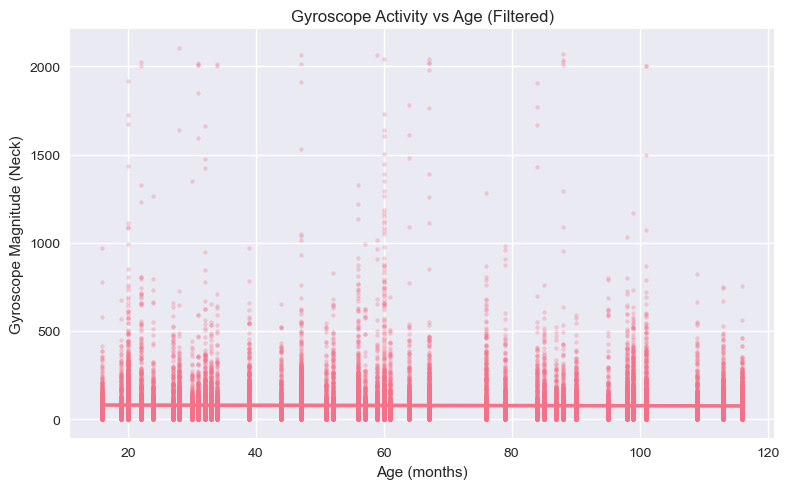

In [30]:
from scipy.stats import pearsonr
import seaborn as sns
import matplotlib.pyplot as plt

# Apply filtering
filtered_df = sensor_analysis[
    (sensor_analysis['Task'] != '<undefined>') &
    (sensor_analysis['Behavior_1']!= '<undefined>')
][['Age months', 'GyroNeck_Mag']].dropna()

# Pearson correlation
r_age, p_age = pearsonr(filtered_df['Age months'], filtered_df['GyroNeck_Mag'])
print(f"📊 Pearson Correlation (Age vs Gyroscope): r = {r_age:.4f}, p = {p_age:.4e}")

# Plot
plt.figure(figsize=(8, 5))
sns.regplot(data=filtered_df, x='Age months', y='GyroNeck_Mag', scatter_kws={'alpha': 0.3, 's': 10})
plt.title('Gyroscope Activity vs Age (Filtered)')
plt.xlabel('Age (months)')
plt.ylabel('Gyroscope Magnitude (Neck)')
plt.tight_layout()
plt.show()


📈 2. Weight vs Gyroscope Magnitude

📊 Pearson Correlation (Weight vs Gyroscope): r = -0.0244, p = 2.5347e-05


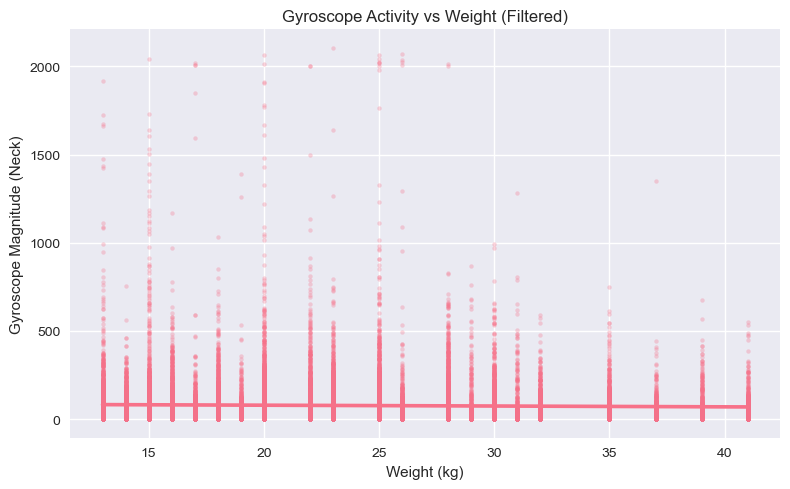

In [31]:
# Apply filtering
filtered_df = sensor_analysis[
    (sensor_analysis['Task'] != '<undefined>') &
    (sensor_analysis['Behavior_1'] != '<undefined>')
][['Weight', 'GyroNeck_Mag']].dropna()

# Pearson correlation
r_weight, p_weight = pearsonr(filtered_df['Weight'], filtered_df['GyroNeck_Mag'])
print(f"📊 Pearson Correlation (Weight vs Gyroscope): r = {r_weight:.4f}, p = {p_weight:.4e}")

# Plot
plt.figure(figsize=(8, 5))
sns.regplot(data=filtered_df, x='Weight', y='GyroNeck_Mag', scatter_kws={'alpha': 0.3, 's': 10})
plt.title('Gyroscope Activity vs Weight (Filtered)')
plt.xlabel('Weight (kg)')
plt.ylabel('Gyroscope Magnitude (Neck)')
plt.tight_layout()
plt.show()


📈 3. Breed vs Gyroscope Magnitude

📊 ANOVA (Breed vs Gyroscope): F = 6.9971, p = 2.2609e-24


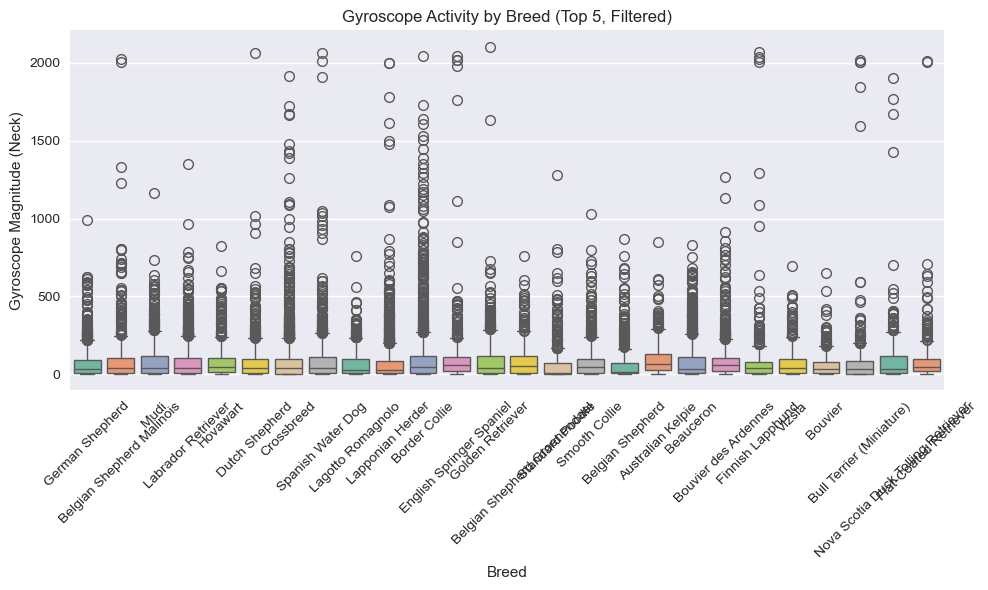

In [32]:
from scipy.stats import f_oneway

# Filter data for valid task and behavior
filtered_df = sensor_analysis[
    (sensor_analysis['Task'] != '<undefined>') &
    (sensor_analysis['Behavior_1'] != '<undefined>') &
    (sensor_analysis['GyroNeck_Mag'].notna())
]

# Select top 5 breeds by count
top_breeds = filtered_df['Breed'].value_counts().head(50).index
breed_subset = filtered_df[filtered_df['Breed'].isin(top_breeds)]

# Prepare groups for ANOVA
breed_groups = [breed_subset[breed_subset['Breed'] == breed]['GyroNeck_Mag'] for breed in top_breeds]

# ANOVA
f_stat, p_val = f_oneway(*breed_groups)
print(f"📊 ANOVA (Breed vs Gyroscope): F = {f_stat:.4f}, p = {p_val:.4e}")

# Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=breed_subset, x='Breed', y='GyroNeck_Mag', palette='Set2')
plt.title('Gyroscope Activity by Breed (Top 5, Filtered)')
plt.xlabel('Breed')
plt.ylabel('Gyroscope Magnitude (Neck)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [33]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Run Tukey HSD
tukey = pairwise_tukeyhsd(endog=breed_subset['GyroNeck_Mag'],
                          groups=breed_subset['Breed'],
                          alpha=0.05)

print(tukey)

                             Multiple Comparison of Means - Tukey HSD, FWER=0.05                              
              group1                             group2               meandiff p-adj   lower    upper   reject
--------------------------------------------------------------------------------------------------------------
                 Australian Kelpie                          Beauceron -24.0239 0.1222 -50.0795   2.0318  False
                 Australian Kelpie                   Belgian Shepherd -33.4245 0.0257 -65.2037  -1.6454   True
                 Australian Kelpie       Belgian Shepherd Groenendael -18.3509 0.9015  -49.195  12.4933  False
                 Australian Kelpie          Belgian Shepherd Malinois -10.8397 0.9998  -39.368  17.6887  False
                 Australian Kelpie                      Border Collie  -5.2035    1.0 -30.2114  19.8043  False
                 Australian Kelpie                            Bouvier  -44.805 0.0001  -76.248  -13.362   True
 

In [34]:
import pandas as pd

# Convert Tukey HSD results into a DataFrame
tukey_df = pd.DataFrame(data=tukey._results_table.data[1:],  # skip header row
                        columns=tukey._results_table.data[0])  # use header row as column names

# Display the DataFrame
print(tukey_df)

                group1                        group2  meandiff   p-adj  \
0    Australian Kelpie                     Beauceron  -24.0239  0.1222   
1    Australian Kelpie              Belgian Shepherd  -33.4245  0.0257   
2    Australian Kelpie  Belgian Shepherd Groenendael  -18.3509  0.9015   
3    Australian Kelpie     Belgian Shepherd Malinois  -10.8397  0.9998   
4    Australian Kelpie                 Border Collie   -5.2035  1.0000   
..                 ...                           ...       ...     ...   
320      Smooth Collie               Standard Poodle   -4.9665  1.0000   
321      Smooth Collie                        Vizsla   -2.8982  1.0000   
322  Spanish Water Dog               Standard Poodle  -13.7203  0.9776   
323  Spanish Water Dog                        Vizsla  -11.6520  0.9956   
324    Standard Poodle                        Vizsla    2.0683  1.0000   

       lower    upper  reject  
0   -50.0795   2.0318   False  
1   -65.2037  -1.6454    True  
2   -49.1950  1

In [35]:
tukey_df[tukey_df['reject'] == True]

,group1,group2,meandiff,p-adj,lower,upper,reject
1,Australian Kelpie,Belgian Shepherd,-33.4245,0.0257,-65.2037,-1.6454,True
5,Australian Kelpie,Bouvier,-44.8050,0.0001,-76.2480,-13.3620,True
7,Australian Kelpie,Bull Terrier (Miniature),-36.4565,0.0008,-64.9543,-7.9588,True
8,Australian Kelpie,Crossbreed,-27.4772,0.0106,-52.1277,-2.8266,True
11,Australian Kelpie,Finnish Lapphund,-31.2689,0.0116,-59.4787,-3.0590,True
13,Australian Kelpie,German Shepherd,-35.4349,0.0001,-61.1833,-9.6865,True
16,Australian Kelpie,Labrador Retriever,-27.4188,0.0142,-52.4632,-2.3743,True
17,Australian Kelpie,Lagotto Romagnolo,-39.6120,0.0000,-66.7950,-12.4290,True
18,Australian Kelpie,Lapponian Herder,-32.8944,0.0005,-58.0892,-7.6996,True
28,Beauceron,Border Collie,18.8203,0.0022,3.3580,34.2826,True


# DogCentric Activity Dataset

DogCentric Activity Dataset is composed of dog activity videos taken from a first-person animal viewpoint. The dataset contains 10 different types of activities, including activities performed by the dog himself/herself, interactions between people and the dog, and activities performed by people or cars.

Labels: ‘Playing with a ball’, ‘waiting for a car to passed by’, ‘drinking water’, ‘feeding’, ‘turning dog’s head to the left’, ‘turning dog’s
head to the right’, ‘petting’, ‘shaking dog’s body by himself’, ‘sniffing’, and ‘walking’

Global motion and local motion

## Source
https://robotics.ait.kyushu-u.ac.jp/yumi/db/first_dog.html

### Individual Feature Accuracy

- **Optical Flow:** 41.7%
- **LBP:** 34.5%
- **Cuboids:** 55.3%
- **STIP-HOG:** 48.6%
- **STIP-HOF:** 51.2%

### Combined Features Accuracy

- **Linear kernel:** 52.6%
- **RBF kernel:** 54.2%
- **Histogram Intersection kernel:** 57.3%
- **Best:** Multi-channel χ² kernel – 60.5%

---

### Conclusions & Insights

- **Key Insight:** Different activity types are best captured by different motion descriptors (e.g., STIP-HOF is best for walking, cuboids are best for petting).
- **Importance of Integration:** Combining global and local motion descriptors using multi-channel kernels significantly improves classification.
- **Future Directions:**
  - Using multiple miniaturized cameras to capture more comprehensive egocentric perspectives.
  - Exploring better representations of ego-motion-heavy activities.


# DECADE ego centric videos

- Learn to act like a dog (predicting the dog’s future moves)
    - Models: CNN (baseline), LstmImg2LastImus
- Learn to plan like a dog (estimating a sequence of movements that take the state of the dog’s world from what is observed at a given time to a desired observed state)
    - Models: CNN (baseline), LstmImg2ActionPlanning
- Learn from a dog (exploring the potentials of using the dog's movements for representation learning).
    - Models: ResNet-18 (Siamese, two-towers shared weights)

## Source

https://github.com/ehsanik/dogTorch

